Project 2: Ames Housing Data and Kaggle Challenge

Problem Statement:
    To create a regression model to predict the sales price for each house

In [1]:
import random as rand
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import imp
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn import metrics
from sklearn import feature_extraction 
from sklearn.metrics import r2_score, mean_squared_error

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
ames_train = pd.read_csv('datasets/train.csv')

In [3]:
def explore(df):
    print(df.shape)
    print("")
    print(df.head())
    print("")
    print(df.dtypes)
    print("")
    print(df.isnull().sum())
    print("")
    print(df.describe())
    
explore(ames_train)

(2051, 81)

    Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   
3  318  916386060           60        RL          73.0      9802   Pave   NaN   
4  255  906425045           50        RL          82.0     14235   Pave   NaN   

  Lot Shape Land Contour Utilities Lot Config Land Slope Neighborhood  \
0       IR1          Lvl    AllPub    CulDSac        Gtl       Sawyer   
1       IR1          Lvl    AllPub    CulDSac        Gtl      SawyerW   
2       Reg          Lvl    AllPub     Inside        Gtl        NAmes   
3       Reg          Lvl    AllPub     Inside        Gtl       Timber   
4       IR1          Lvl    AllPub     Inside        Gtl      SawyerW   

  Condition 1 Condition 2 Bldg Type House Style  Overall Qual 

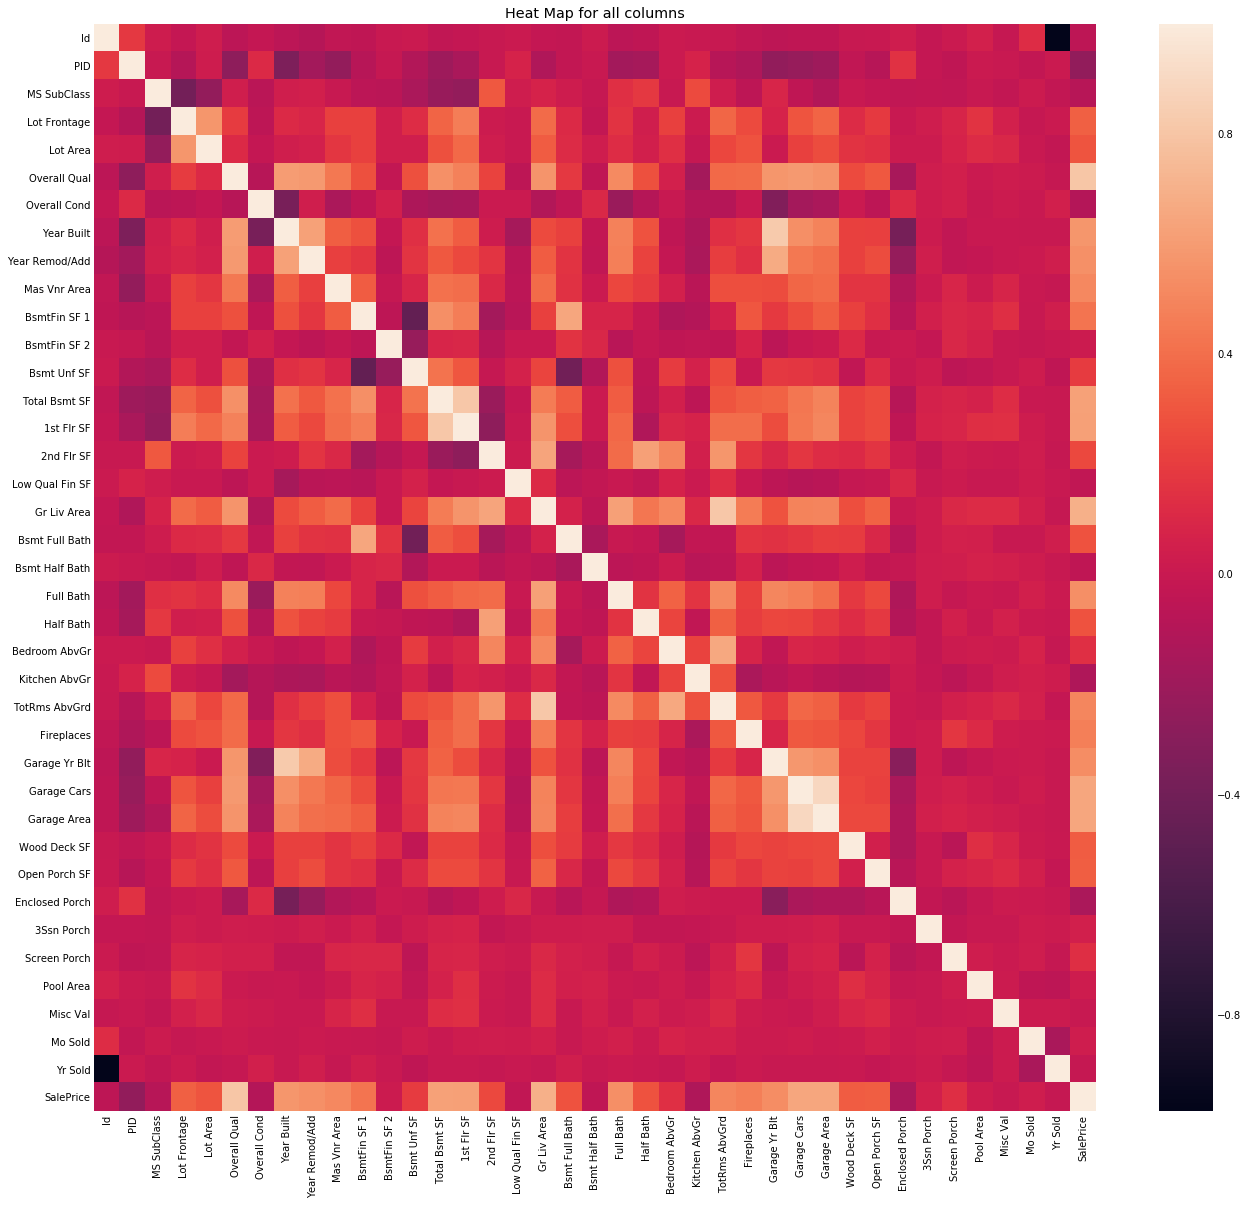

In [4]:
#to find out the general correlation between variables first
fig, ax = plt.subplots(figsize=(20,20)) 
ax.set_title('Heat Map for all columns')
sns.heatmap(ames_train.corr(), ax = ax, annot=False, annot_kws={"size": 20})

In [5]:
#Replacing the np.nan cells to their respective column values

ames_train['Lot Frontage'] = ames_train['Lot Frontage'].replace({np.nan:0})
#Changing to NA for no alley access
ames_train['Alley'] = ames_train['Alley'].replace({np.nan:'NA'})

#both 'Mas Vnr Type' and 'Mas Vnr Area' are 22 entries that are tied to each other
ames_train['Mas Vnr Type'] = ames_train['Mas Vnr Type'].replace({np.nan:'None'})
ames_train['Mas Vnr Area'] = ames_train['Mas Vnr Area'].replace({np.nan:0})

#55 entries without basement
ames_train['Bsmt Qual'] = ames_train['Bsmt Qual'].replace({np.nan:'NA'})
ames_train['Bsmt Cond'] = ames_train['Bsmt Cond'].replace({np.nan:'NA'})

#These three cells has a basement but their exposure is unknown
ames_train.iloc[1456, ames_train.columns.get_loc('Bsmt Exposure')] = 'No'
ames_train.iloc[1547, ames_train.columns.get_loc('Bsmt Exposure')] = 'No'
ames_train.iloc[1997, ames_train.columns.get_loc('Bsmt Exposure')] = 'No'

#entries without basement
ames_train['Bsmt Exposure'] = ames_train['Bsmt Exposure'].replace({np.nan:'NA'})
ames_train['BsmtFin Type 1'] = ames_train['BsmtFin Type 1'].replace({np.nan:'NA'})
ames_train['BsmtFin SF 1'] = ames_train['BsmtFin SF 1'].replace({np.nan:0})
ames_train['BsmtFin Type 2'] = ames_train['BsmtFin Type 2'].replace({np.nan:'NA'})
ames_train['BsmtFin SF 2'] = ames_train['BsmtFin SF 2'].replace({np.nan:0})
ames_train['Bsmt Unf SF'] = ames_train['Bsmt Unf SF'].replace({np.nan:0})
ames_train['Total Bsmt SF'] = ames_train['Total Bsmt SF'].replace({np.nan:0})
ames_train['Bsmt Full Bath'] = ames_train['Bsmt Full Bath'].replace({np.nan:0})
ames_train['Bsmt Half Bath'] = ames_train['Bsmt Half Bath'].replace({np.nan:0})

#All fireplace Qu with np.nan is does not have a fireplace.
ames_train['Fireplace Qu'] = ames_train['Fireplace Qu'].replace({np.nan:'NA'})

#All except for row1712, does not have a garage. 
ames_train['Garage Type'] = ames_train['Garage Type'].replace({np.nan:'NA'})
ames_train.iloc[1712, ames_train.columns.get_loc('Garage Yr Blt')] = ames_train.iloc[1712, ames_train.columns.get_loc('Year Remod/Add')]
ames_train['Garage Yr Blt'] = ames_train['Garage Yr Blt'].replace({np.nan:0})
ames_train['Garage Finish'] = ames_train['Garage Finish'].replace({np.nan:'NA'})
ames_train['Garage Cars'] = ames_train['Garage Cars'].replace({np.nan:0})
ames_train['Garage Area'] = ames_train['Garage Area'].replace({np.nan:0})
ames_train['Garage Qual'] = ames_train['Garage Qual'].replace({np.nan:'NA'})
ames_train['Garage Cond'] = ames_train['Garage Cond'].replace({np.nan:'NA'})


#All Pool QC with np.nan has pool area of 0
ames_train['Pool QC'] = ames_train['Pool QC'].replace({np.nan:'NA'})
ames_train['Fence'] = ames_train['Fence'].replace({np.nan:'NA'})
ames_train['Misc Feature'] = ames_train['Misc Feature'].replace({np.nan:'NA'})

In [6]:
#encoding each ordinal categorical features, full glossary in readme
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


def transform(col):
    for i in col:
        le.fit(ames_train[i])
        list(le.classes_)
        ames_train[i] = le.transform(ames_train[i])

columns = ['Lot Shape',
           'Utilities',
           'Land Slope',
           'Exter Qual',
           'Exter Cond',
           'Bsmt Qual',
           'Bsmt Cond',
           'Bsmt Exposure',
           'BsmtFin Type 1',
           'BsmtFin Type 2',
           'Heating QC',
           'Electrical',
           'Kitchen Qual',
           'Functional',
           'Fireplace Qu',
           'Garage Finish',
           'Garage Qual',
           'Garage Cond',
           'Paved Drive',
           'Pool QC',
           'Fence']

transform(columns)

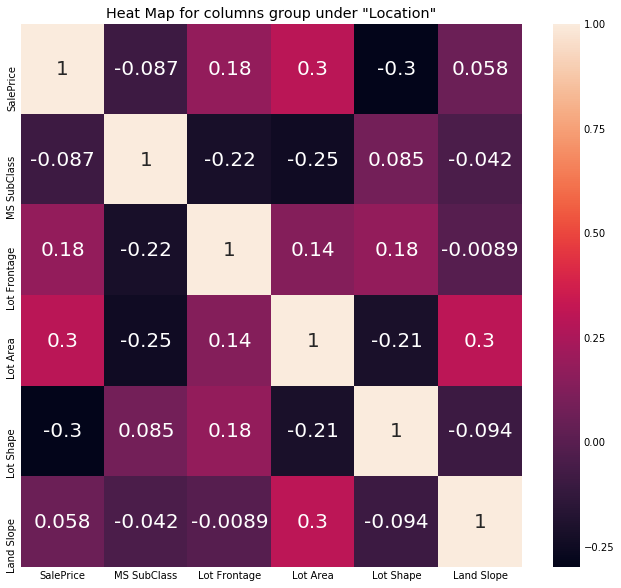

In [7]:
#to find out the general correlation between variables first, based on Location
fig, ax = plt.subplots(figsize=(10,10)) 
ax.set_title('Heat Map for columns group under "Location"')
sns.heatmap(ames_train[['SalePrice','MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Alley',
                        'Lot Shape', 'Land Contour', 'Lot Config', 'Land Slope','Neighborhood',
                        'Condition 1','Condition 2']].corr(), ax = ax, annot=True, annot_kws={"size": 20})

#select lot shape and lot area to do feature engineering

In [8]:
poly = PolynomialFeatures(degree=2,include_bias=False)

In [9]:
location = ames_train[['Lot Area','Lot Shape']]
location.shape

(2051, 2)

In [10]:
location_poly = poly.fit_transform(location)
location_poly = pd.DataFrame(location_poly, columns = poly.get_feature_names(location.columns))

In [11]:
location_poly['SalePrice']=ames_train['SalePrice']

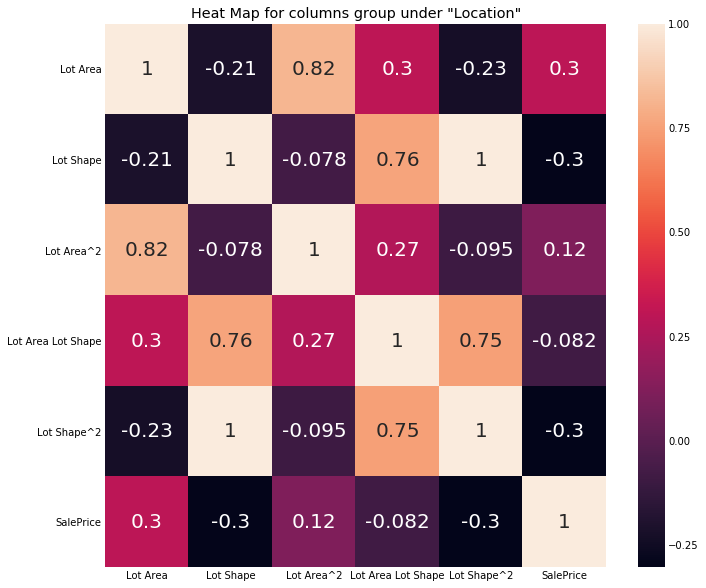

In [12]:
#check again if there are any additional features to add
fig, ax = plt.subplots(figsize=(10,10)) 
ax.set_title('Heat Map for columns group under "Location"')
sns.heatmap(location_poly.corr(), ax = ax, annot=True, annot_kws={"size": 20})

#Conclusion: no useable features here

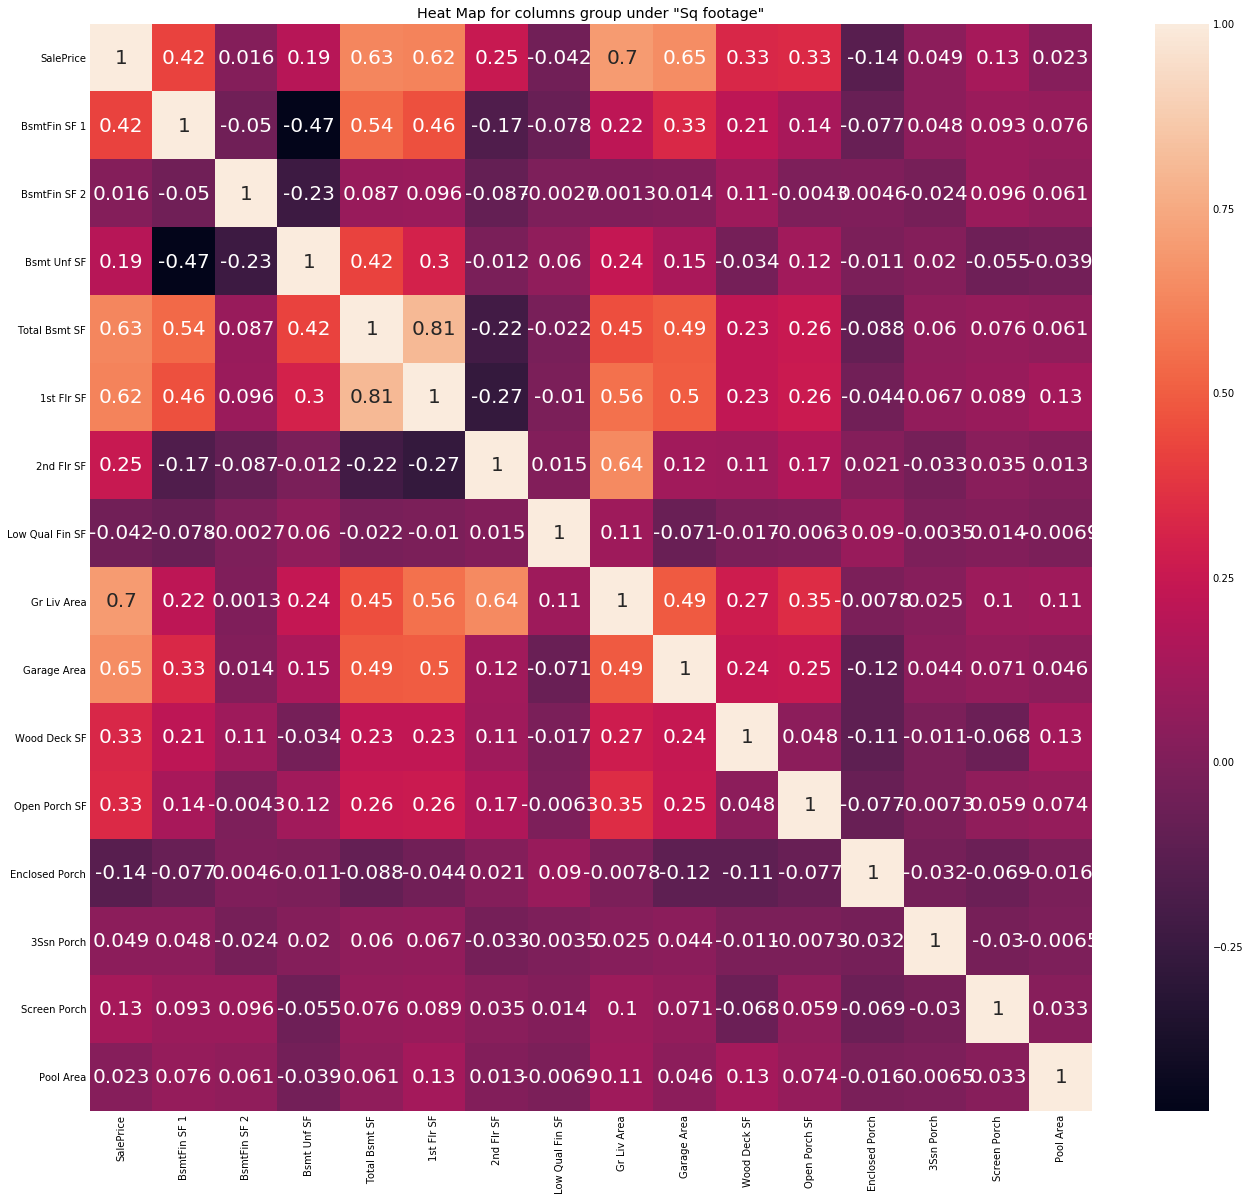

In [13]:
#to find out the general correlation between variables first, Sq footage
fig, ax = plt.subplots(figsize=(20,20)) 
ax.set_title('Heat Map for columns group under "Sq footage"')
sns.heatmap(ames_train[['SalePrice','BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF',
                        'Low Qual Fin SF', 'Gr Liv Area', 'Garage Area', 'Wood Deck SF','Open Porch SF',
                        'Enclosed Porch','3Ssn Porch','Screen Porch','Pool Area']].corr(), 
            ax = ax, annot=True, annot_kws={"size": 20})

#Use Total Bsmt SF, 1st Flr SF, Gr Liv Area, Garage Area

In [14]:
area = ames_train[['Total Bsmt SF', '1st Flr SF','Gr Liv Area', 'Garage Area']]
area.shape

(2051, 4)

In [15]:
area_poly = poly.fit_transform(area)
area_poly = pd.DataFrame(area_poly, columns = poly.get_feature_names(area.columns))

In [16]:
area_poly['SalePrice']=ames_train['SalePrice']
area_poly['Total Sq']= ames_train['Total Bsmt SF']+ames_train['1st Flr SF']+ames_train['Gr Liv Area']+ames_train['Garage Area']

#Added a new feature to add all square foot together

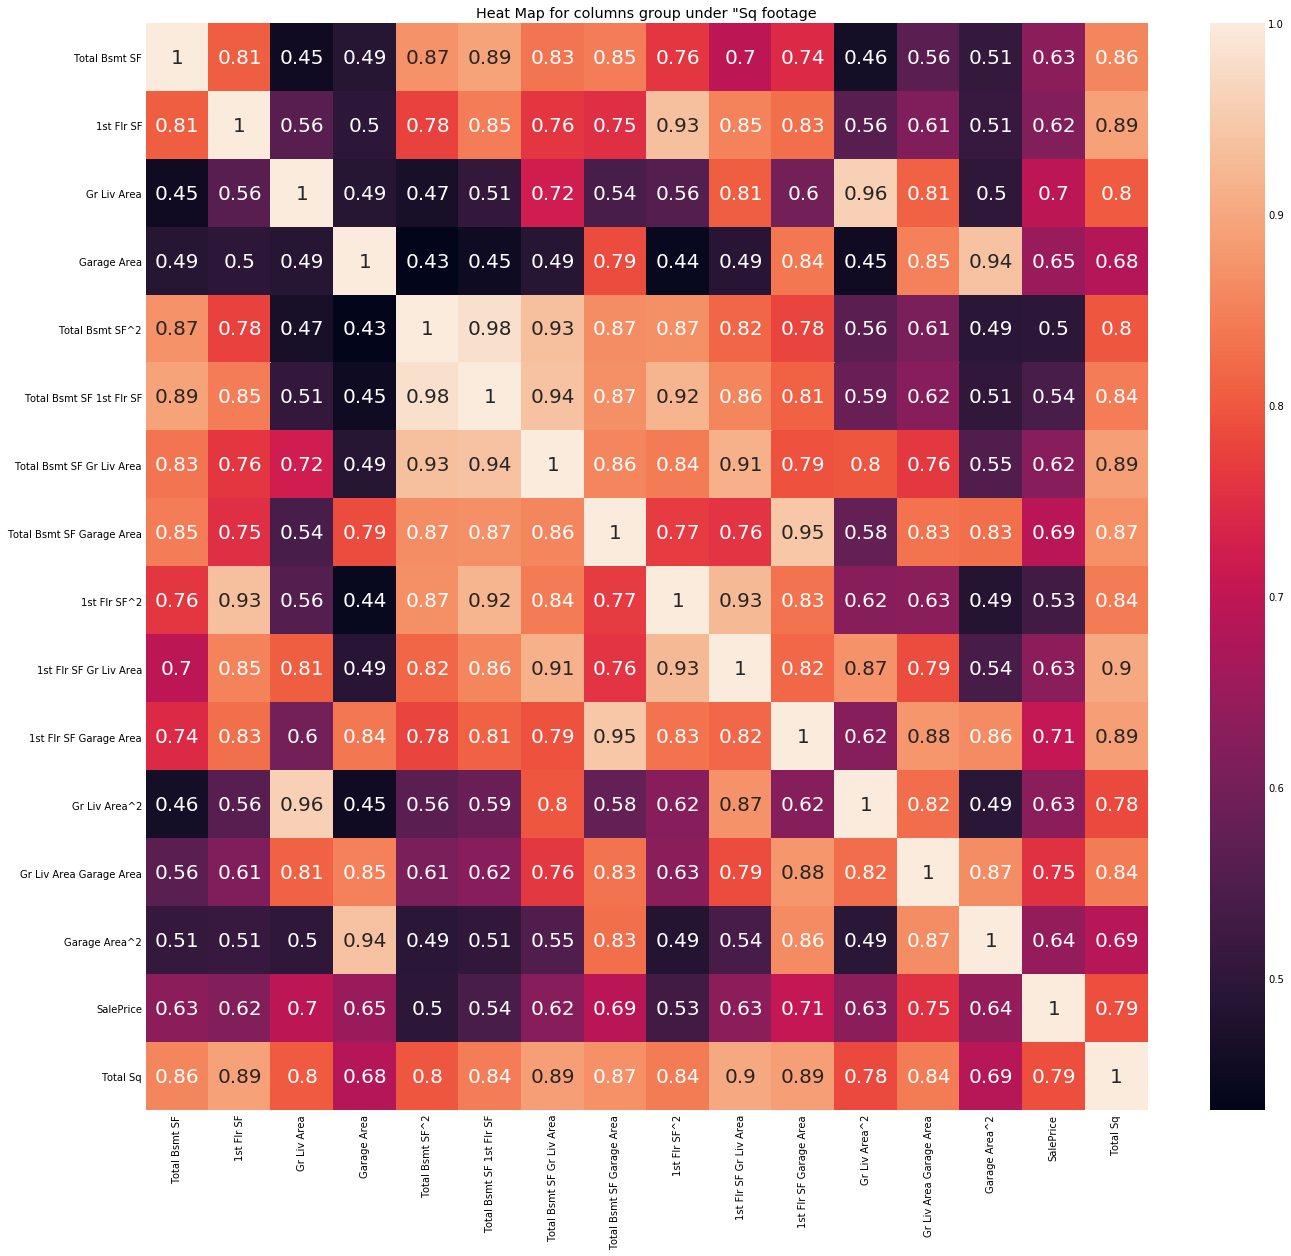

In [17]:
#check again if there are any additional features to add
fig, ax = plt.subplots(figsize=(20,20)) 
ax.set_title('Heat Map for columns group under "Sq footage')
sns.heatmap(area_poly.corr(), ax = ax, annot=True, annot_kws={"size": 20})

#Conclusion: Keep 'Gr Liv Area'
#Include: '1st Flr SF Garage Area', 'Gr Liv Area Garage Area', 'Total Sq'

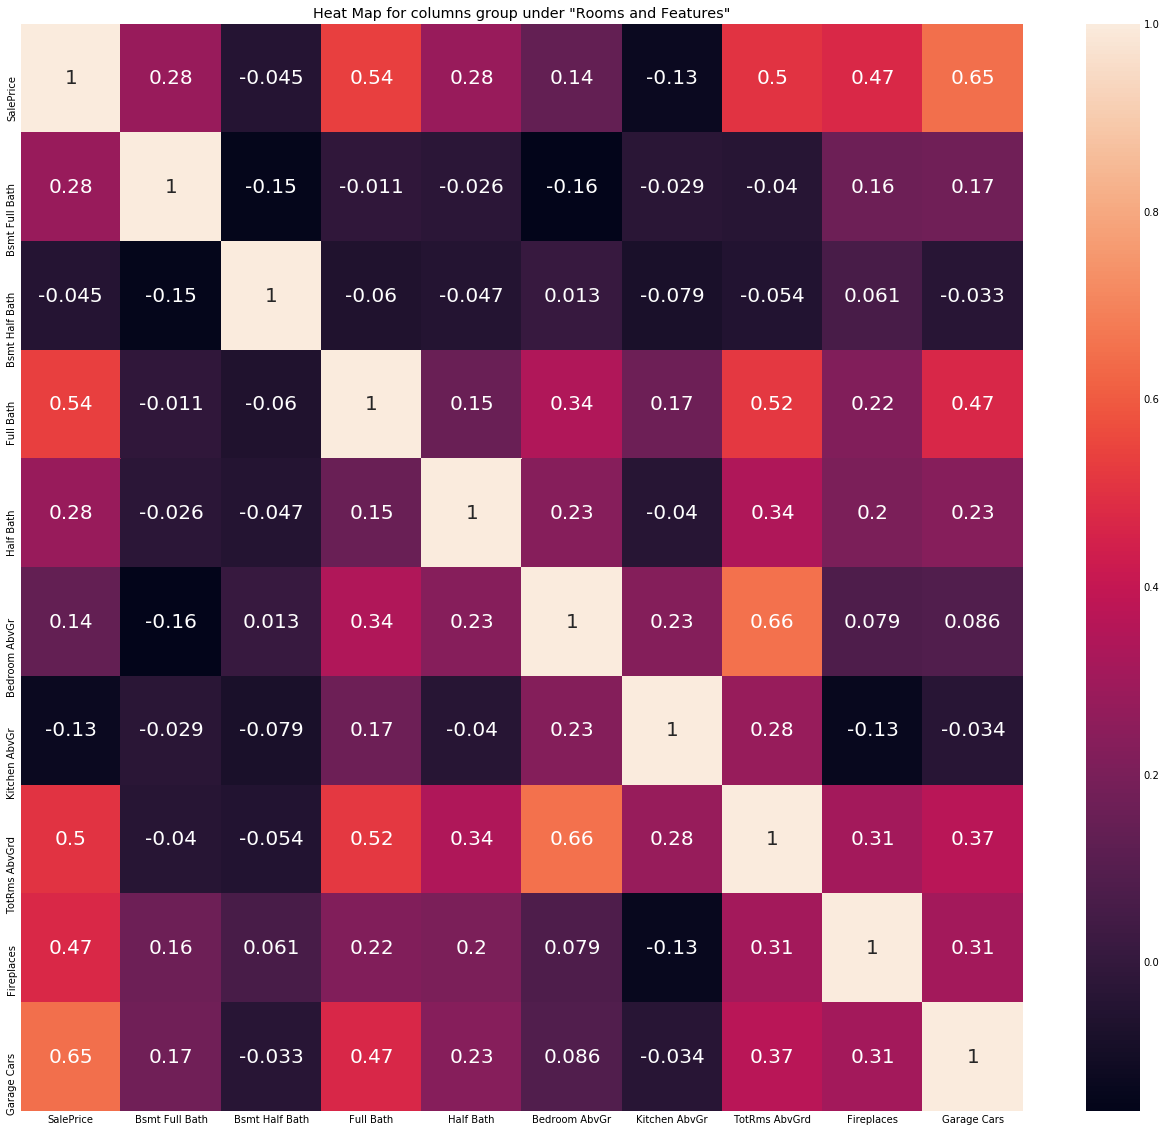

In [18]:
#to find out the general correlation between variables first, Rooms/Features
fig, ax = plt.subplots(figsize=(20,20)) 
ax.set_title('Heat Map for columns group under "Rooms and Features"')
sns.heatmap(ames_train[['SalePrice','Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr',
                        'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']].corr(), 
            ax = ax, annot=True, annot_kws={"size": 20})

#Use Full Bath, Total Rms Above Grd, Fireplaces, Garage Cars for poly features

In [19]:
rooms = ames_train[['Full Bath', 'TotRms AbvGrd','Fireplaces', 'Garage Cars']]
rooms.shape

(2051, 4)

In [20]:
rooms_poly = poly.fit_transform(rooms)
rooms_poly = pd.DataFrame(rooms_poly, columns = poly.get_feature_names(rooms.columns))

In [21]:
rooms_poly['SalePrice']=ames_train['SalePrice']

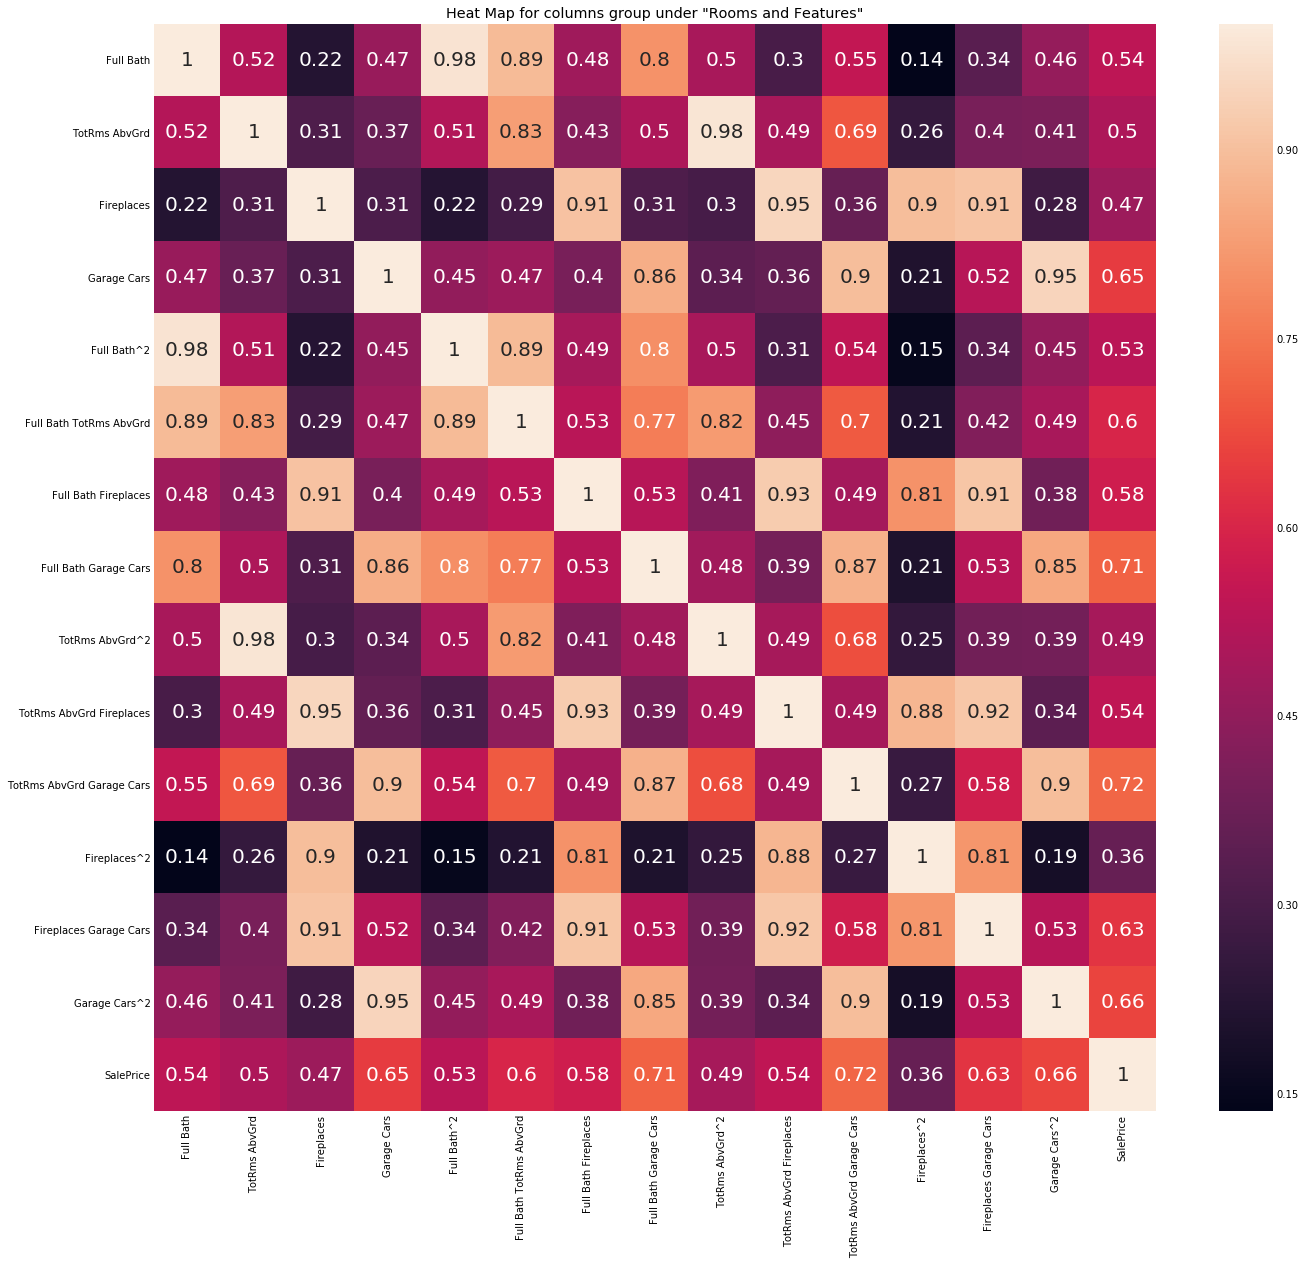

In [22]:
#check again if there are any additional features to add
fig, ax = plt.subplots(figsize=(20,20)) 
ax.set_title('Heat Map for columns group under "Rooms and Features"')
sns.heatmap(rooms_poly.corr(), ax = ax, annot=True, annot_kws={"size": 20})

#Include: 'Garage Cars^2', 'Full Bath Garage Car', 'TotRms AbvGrd Garage Car', 'Full Bath TotRms AbvGrd'

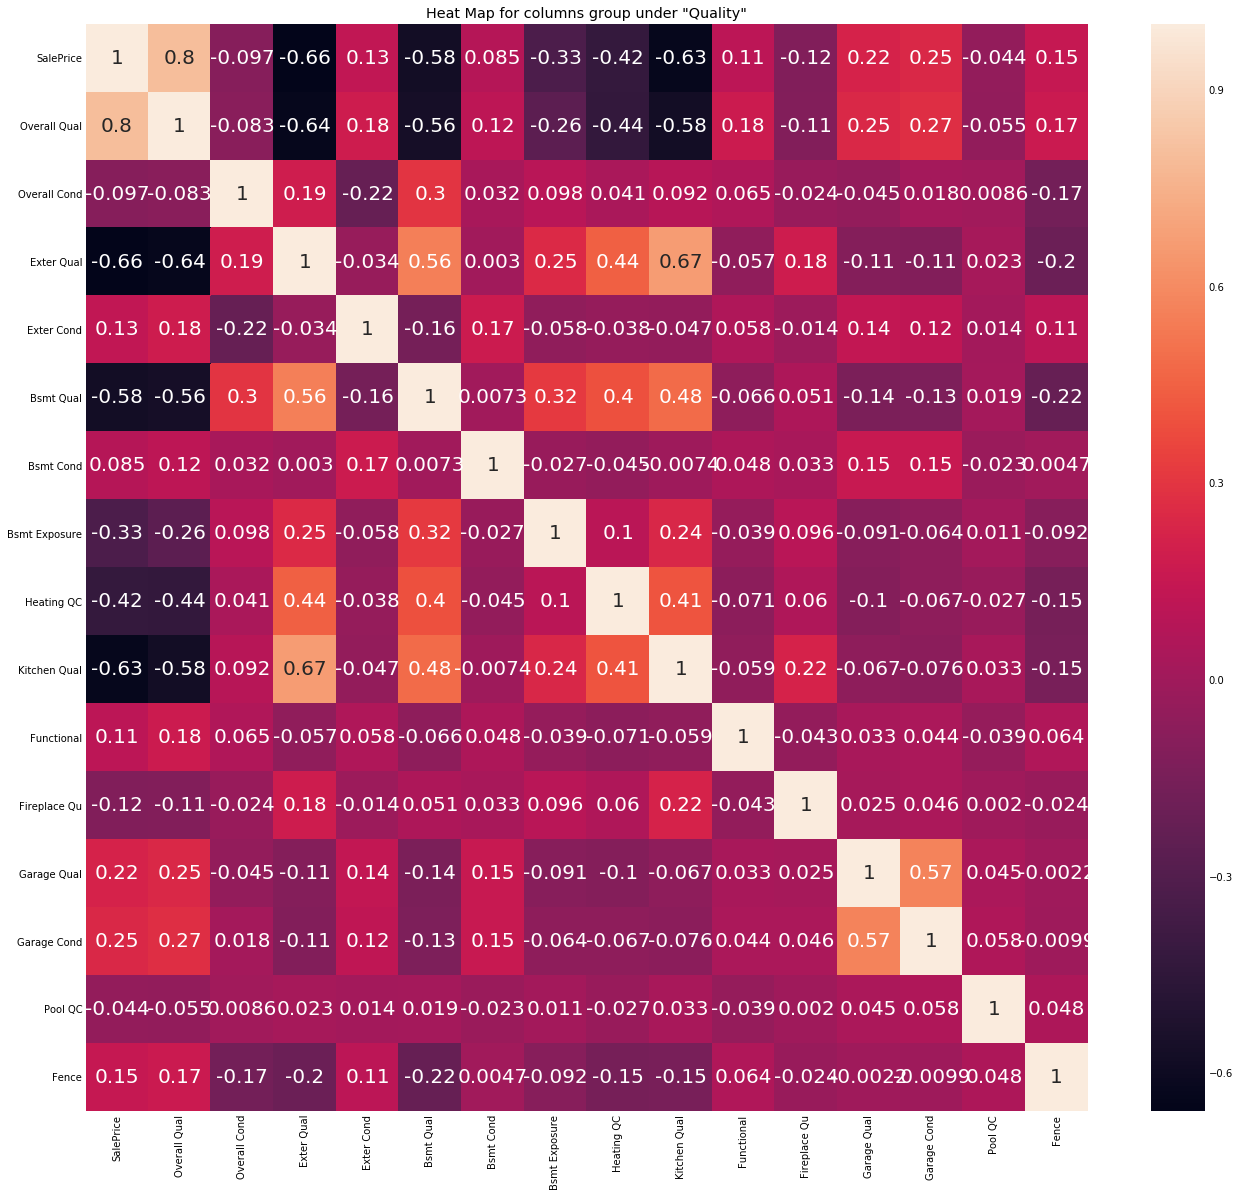

In [23]:
#to find out the general correlation between variables first, Quality
fig, ax = plt.subplots(figsize=(20,20)) 
ax.set_title('Heat Map for columns group under "Quality"')
sns.heatmap(ames_train[['SalePrice','Overall Qual', 'Overall Cond', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond',
                        'Bsmt Exposure', 'Heating QC', 'Kitchen Qual','Functional','Fireplace Qu','Garage Qual','Garage Cond',
                       'Pool QC','Fence']].corr(), 
            ax = ax, annot=True, annot_kws={"size": 20})

#Include Overall Qual, Exter Qual, Bsmt Qual, Kitchen Qual

In [24]:
quality = ames_train[['Overall Qual', 'Exter Qual','Bsmt Qual', 'Kitchen Qual']]
quality.shape

(2051, 4)

In [25]:
quality_poly = poly.fit_transform(quality)
quality_poly = pd.DataFrame(quality_poly, columns = poly.get_feature_names(quality.columns))

In [26]:
quality_poly['SalePrice']=ames_train['SalePrice']

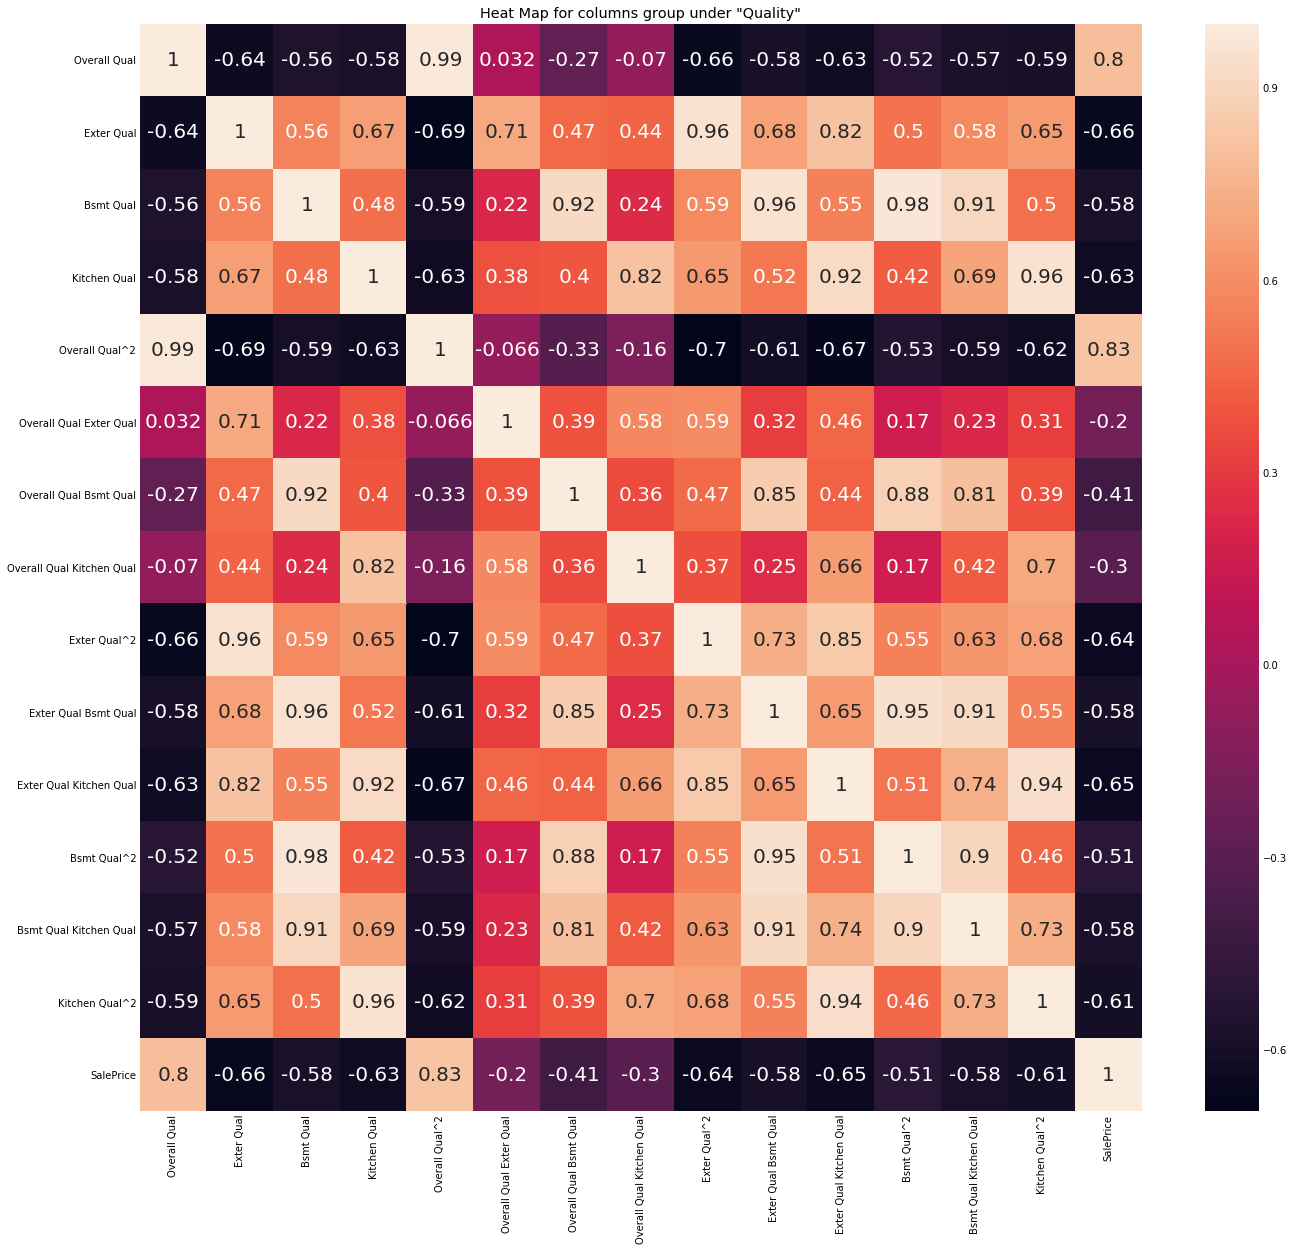

In [27]:
#check again if there are any additional features to add
fig, ax = plt.subplots(figsize=(20,20)) 
ax.set_title('Heat Map for columns group under "Quality"')
sns.heatmap(quality_poly.corr(), ax = ax, annot=True, annot_kws={"size": 20})

#Include: 'Overall Qual^2', Exter Qual, Bsmt Qual, Kitchen Qual

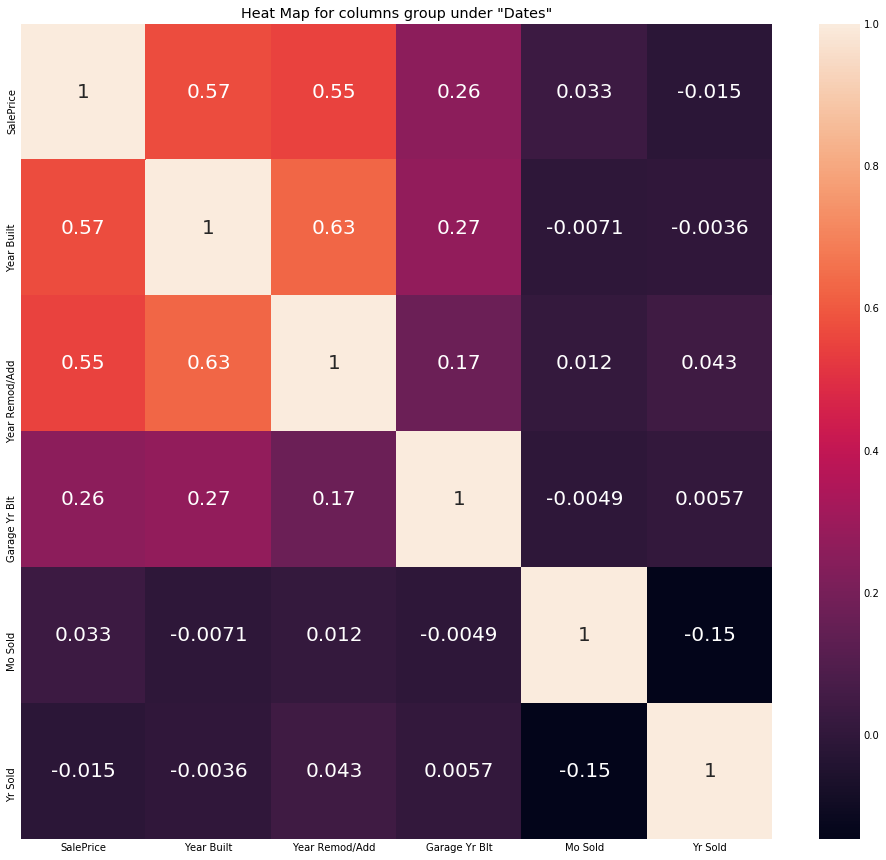

In [28]:
#to find out the general correlation between variables first, dates
fig, ax = plt.subplots(figsize=(15,15)) 
ax.set_title('Heat Map for columns group under "Dates"')
sns.heatmap(ames_train[['SalePrice','Year Built', 'Year Remod/Add', 'Garage Yr Blt', 'Mo Sold', 'Yr Sold']].corr(), 
            ax = ax, annot=True, annot_kws={"size": 20})

#Use 'Year Built', 'Year Remod/Add' for poly features 

In [29]:
dates = ames_train[['Year Built', 'Year Remod/Add']]
dates.shape

(2051, 2)

In [30]:
dates_poly = poly.fit_transform(dates)
dates_poly = pd.DataFrame(dates_poly, columns = poly.get_feature_names(dates.columns))

In [31]:
dates_poly['SalePrice']=ames_train['SalePrice']

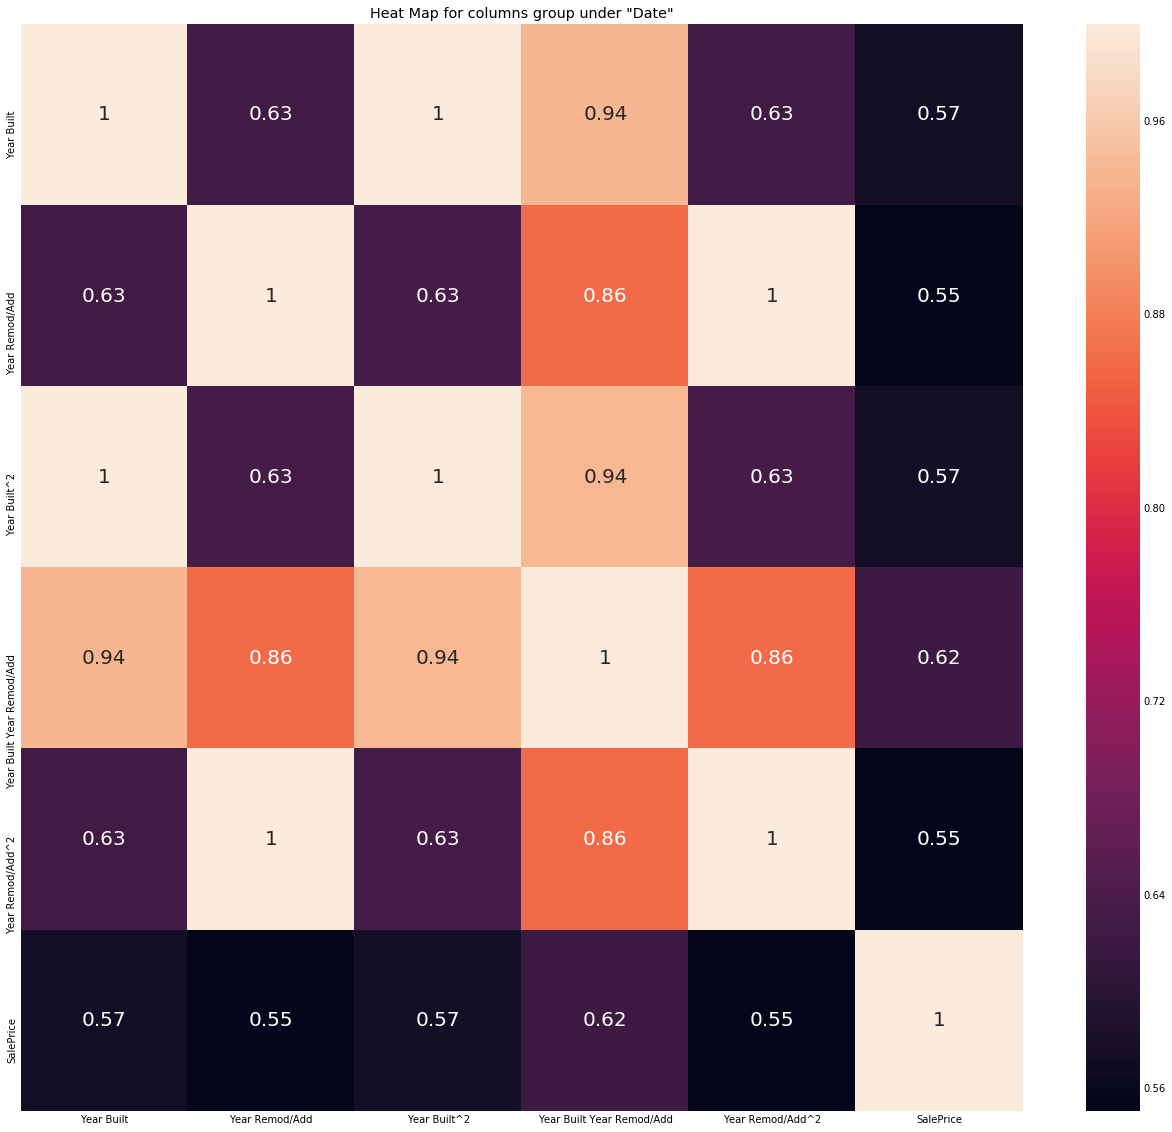

In [32]:
#check again if there are any additional features to add
fig, ax = plt.subplots(figsize=(20,20)) 
ax.set_title('Heat Map for columns group under "Date"')
sns.heatmap(dates_poly.corr(), ax = ax, annot=True, annot_kws={"size": 20})

#Include: 'Year Built Year Remod/Add'

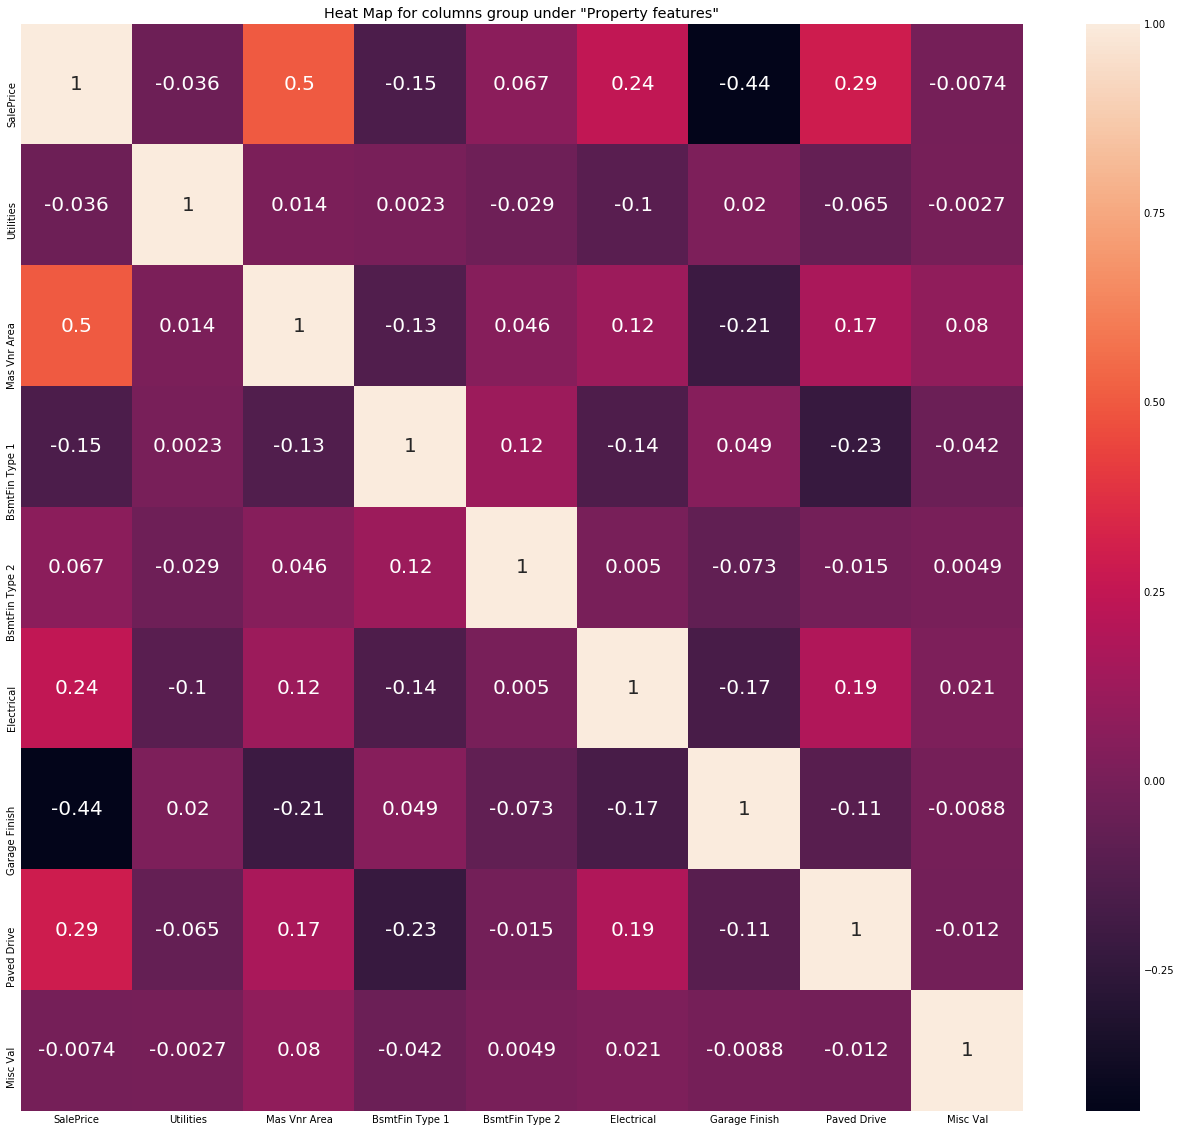

In [33]:
#to find out the general correlation between variables first, Property Features
fig, ax = plt.subplots(figsize=(20,20)) 
ax.set_title('Heat Map for columns group under "Property features"')
sns.heatmap(ames_train[['SalePrice','Utilities', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st',
                        'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area','Foundation','BsmtFin Type 1','BsmtFin Type 2',
                        'Heating','Central Air','Electrical','Garage Type','Garage Finish','Paved Drive',
                       'Misc Feature','Misc Val']].corr(), 
            ax = ax, annot=True, annot_kws={"size": 20})

#Use 'Mas Vnr Area', 'Garage Finish' for poly features 

In [34]:
property_features = ames_train[['Mas Vnr Area', 'Garage Finish']]
property_features.shape

(2051, 2)

In [35]:
property_features_poly = poly.fit_transform(property_features)
property_features_poly = pd.DataFrame(property_features_poly, columns = poly.get_feature_names(property_features.columns))

In [36]:
property_features_poly['SalePrice']=ames_train['SalePrice']

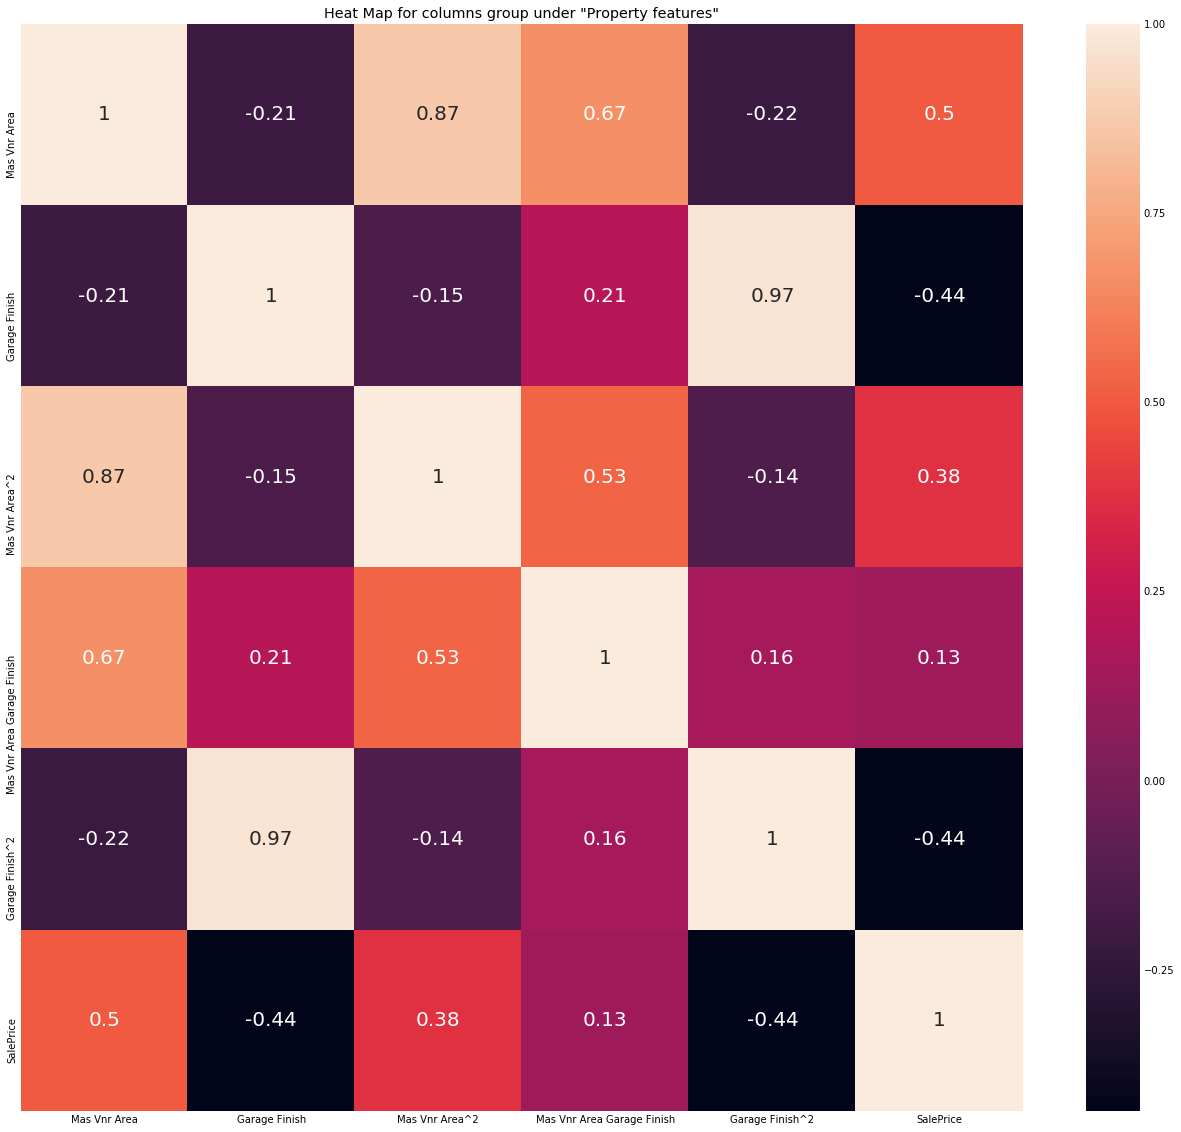

In [37]:
#check again if there are any additional features to add
fig, ax = plt.subplots(figsize=(20,20)) 
ax.set_title('Heat Map for columns group under "Property features"')
sns.heatmap(property_features_poly.corr(), ax = ax, annot=True, annot_kws={"size": 20})

#Drop all

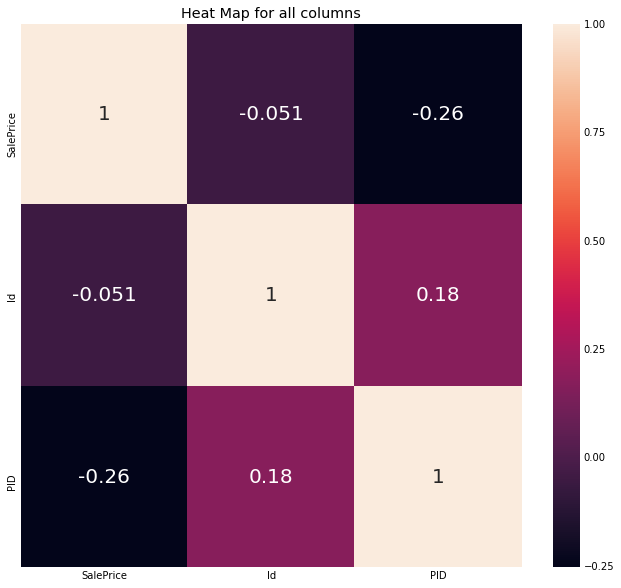

In [38]:
#to find out the general correlation between variables first, Others
fig, ax = plt.subplots(figsize=(10,10)) 
ax.set_title('Heat Map for all columns')
sns.heatmap(ames_train[['SalePrice','Id', 'PID', 'Sale Type']].corr(), 
            ax = ax, annot=True, annot_kws={"size": 20})

#Drop all

In [39]:
area_final = area_poly[['Gr Liv Area','1st Flr SF Garage Area', 'Gr Liv Area Garage Area', 'Total Sq']]

rooms_final = rooms_poly[['Garage Cars^2', 'Full Bath Garage Cars', 'TotRms AbvGrd Garage Cars', 'Full Bath TotRms AbvGrd']]

quality_final = quality_poly[['Overall Qual^2', 'Exter Qual', 'Bsmt Qual', 'Kitchen Qual']]

dates_final = dates_poly[['Year Built Year Remod/Add']]

In [40]:
df2 = pd.concat([area_final,rooms_final,quality_final,dates_final],join = 'outer', axis=1)

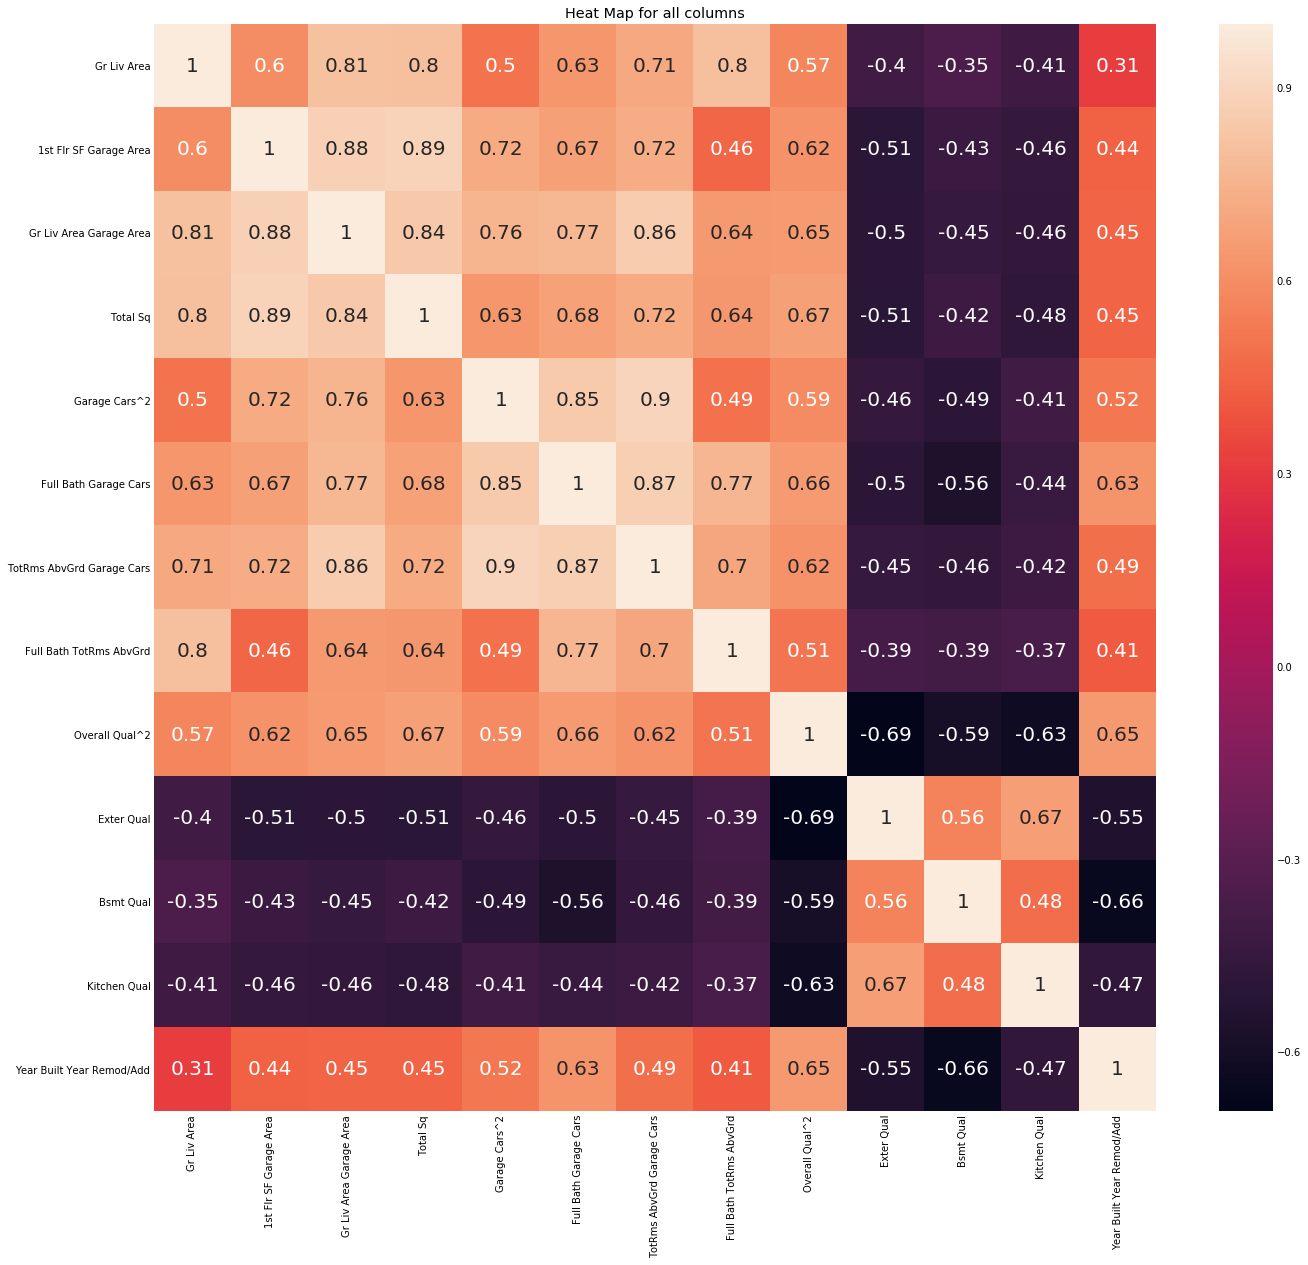

In [41]:
#to find out the general correlation between variables first, Others
fig, ax = plt.subplots(figsize=(20,20)) 
ax.set_title('Heat Map for all columns')
sns.heatmap(df2.corr(), 
            ax = ax, annot=True, annot_kws={"size": 20})

#Drop all

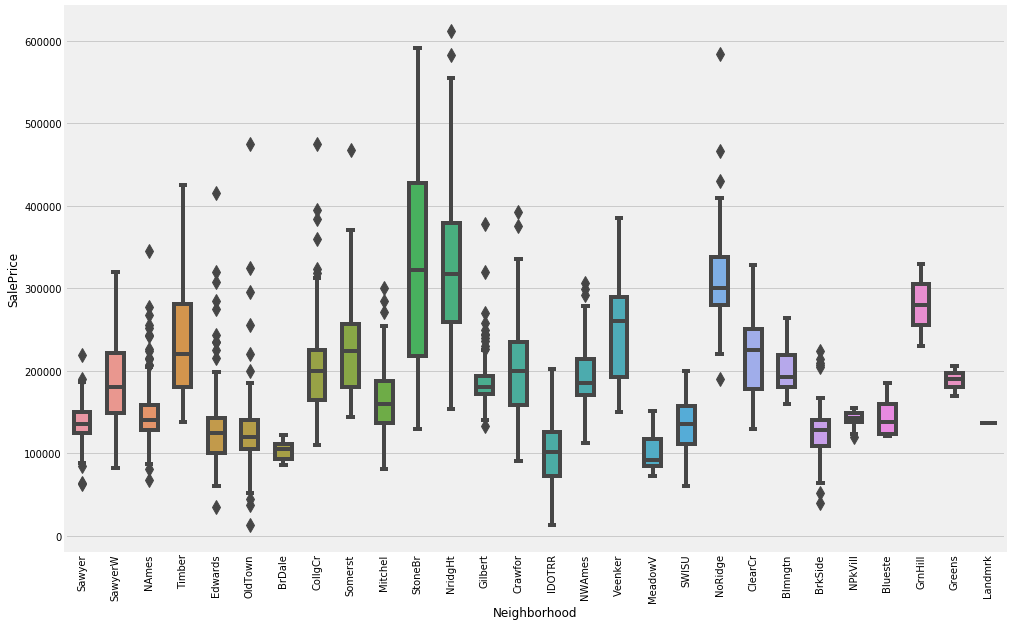

In [42]:
fig, ax = plt.subplots(figsize=(15,10))
plt.xticks(rotation=90)
ax = sns.boxplot(y=ames_train['SalePrice'], x=ames_train['Neighborhood'], orient = 'v', width = 0.5, fliersize = 10).set(
    xlabel='Neighborhood', 
    ylabel='SalePrice')

#No strong distinction between Neighborhood, but worth keeping

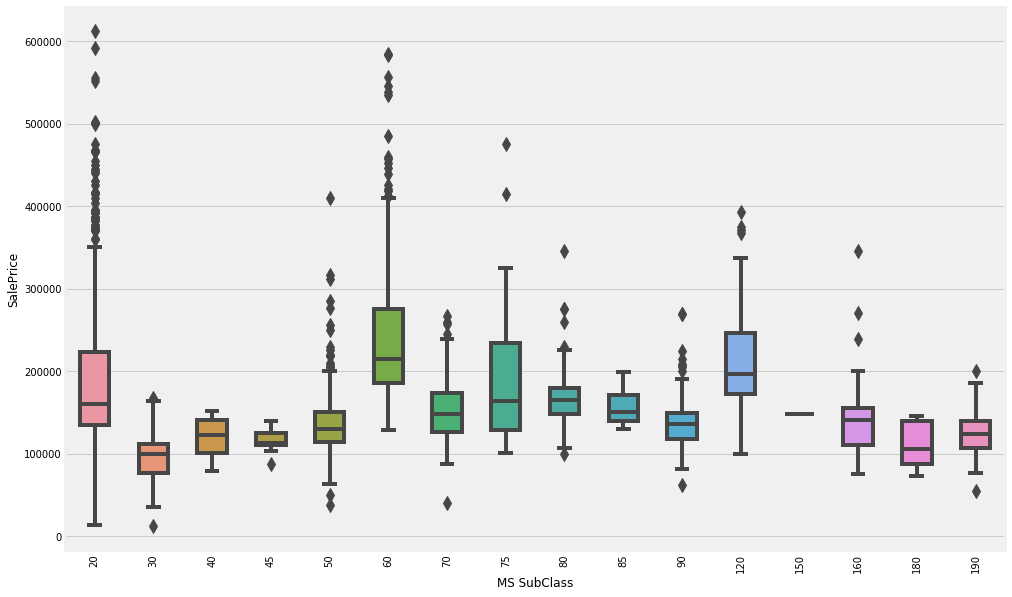

In [43]:
fig, ax = plt.subplots(figsize=(15,10))
plt.xticks(rotation=90)
ax = sns.boxplot(y=ames_train['SalePrice'], x=ames_train['MS SubClass'], orient = 'v', width = 0.5, fliersize = 10).set(
    xlabel='MS SubClass', 
    ylabel='SalePrice')

#Only labels 20, 60 are able to command high prices

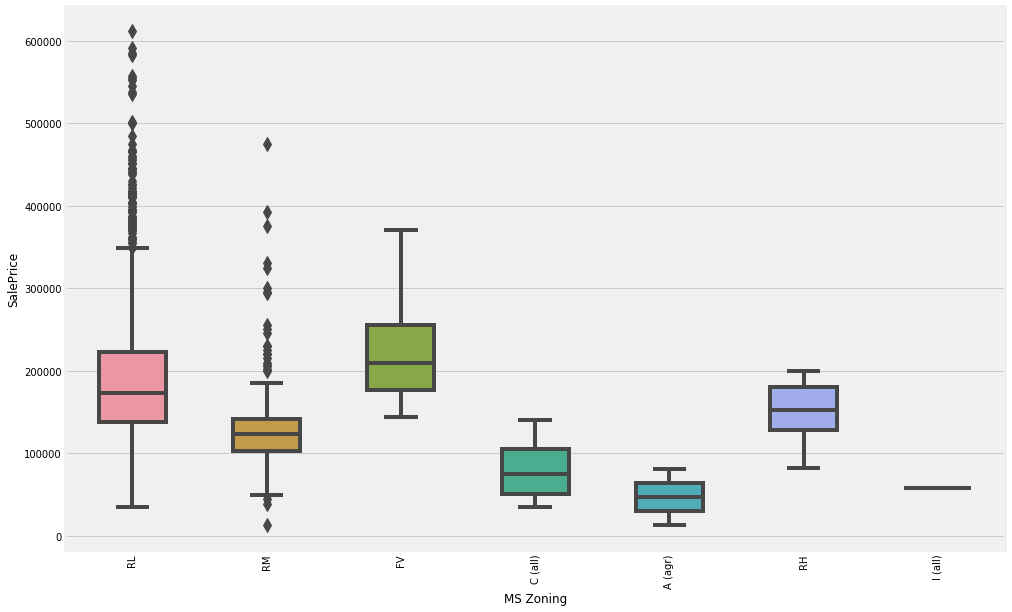

In [44]:
fig, ax = plt.subplots(figsize=(15,10))
plt.xticks(rotation=90)
ax = sns.boxplot(y=ames_train['SalePrice'], x=ames_train['MS Zoning'], orient = 'v', width = 0.5, fliersize = 10).set(
    xlabel='MS Zoning', 
    ylabel='SalePrice')

#Quite clearly shows the bandwidth for different classes

In [45]:
df2 = pd.concat([df2, ames_train[['SalePrice',
                                  'MS SubClass',
         'MS Zoning',
         'Street',
         'Alley',
         'Land Contour',
         'Lot Config',
         'Neighborhood',
         'Condition 1',
         'Condition 2',
         'Bldg Type',
         'House Style',
         'Roof Style',
         'Roof Matl',
         'Exterior 1st',
         'Exterior 2nd',
         'Mas Vnr Type',
         'Foundation',
         'Heating',
         'Central Air',
         'Garage Type',
         'Misc Feature',
         'Sale Type',
        ]]], axis = 1)

In [46]:
#changing all categorical results to dummies
column2= ['MS SubClass',
         'MS Zoning',
         'Street',
         'Alley',
         'Land Contour',
         'Lot Config',
         'Neighborhood',
         'Condition 1',
         'Condition 2',
         'Bldg Type',
         'House Style',
         'Roof Style',
         'Roof Matl',
         'Exterior 1st',
         'Exterior 2nd',
         'Mas Vnr Type',
         'Foundation',
         'Heating',
         'Central Air',
         'Garage Type',
         'Misc Feature',
         'Sale Type']

df2 = pd.get_dummies(data = df2, prefix=column2, columns = column2, drop_first=True)

In [47]:
df2[df2.columns[1:]].corr()['SalePrice'][:].sort_values(ascending=False)

SalePrice                    1.000000
Overall Qual^2               0.825539
Total Sq                     0.789991
Gr Liv Area Garage Area      0.754659
TotRms AbvGrd Garage Cars    0.720034
Full Bath Garage Cars        0.714775
1st Flr SF Garage Area       0.705365
Garage Cars^2                0.664522
Year Built Year Remod/Add    0.622283
Full Bath TotRms AbvGrd      0.601315
Foundation_PConc             0.529047
Neighborhood_NridgHt         0.448647
Sale Type_New                0.358102
Garage Type_Attchd           0.357879
MS SubClass_60               0.355421
Exterior 1st_VinylSd         0.342146
Exterior 2nd_VinylSd         0.337563
Mas Vnr Type_Stone           0.310026
Central Air_Y                0.277378
Roof Style_Hip               0.265224
Neighborhood_NoRidge         0.263395
Mas Vnr Type_BrkFace         0.257901
Neighborhood_StoneBr         0.256977
MS Zoning_RL                 0.231468
Garage Type_BuiltIn          0.219820
Land Contour_HLS             0.212245
House Style_

In [48]:
#Split df so that SalePrice is not included
#log the SalePrice to deduce the values
X = pd.concat([df2.iloc[:,:13],df2.iloc[:,14:]],axis = 1)
y = np.log(ames_train.SalePrice)

In [49]:
#Train,test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20 , train_size=0.7 , test_size=0.3)

In [50]:
ss = StandardScaler()

In [51]:
#Scale data after train,test split
#fit transform train data only
#only transform test data based on the parameters of training data

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  


In [52]:
#Try using linear regression
linreg = LinearRegression()
model = linreg.fit(Xs_train,y_train)
linreg_scores = cross_val_score(model, X, y, cv=10)

print (linreg_scores)
print (np.mean(linreg_scores))

[0.72681457 0.77462178 0.82284474 0.8040974  0.59939749 0.920662
 0.81686301 0.81457222 0.89470463 0.79394261]
0.7968520449889573


In [53]:
#Try Lasso
optimal_lasso = LassoCV(n_alphas=1000, cv=10, verbose=1)
optimal_lasso.fit(Xs_train, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.00434537430272169


....................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.4s finished


In [54]:
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, X, y, cv=10)

print (lasso_scores)
print (np.mean(lasso_scores))
#improved by about 3% from linear regression

[0.78900715 0.83884742 0.86404616 0.89980622 0.7111917  0.87773982
 0.86675413 0.77398237 0.88025166 0.78309717]
0.8284723799193356


In [55]:
lasso.fit(Xs_train, y_train)

Lasso(alpha=0.00434537430272169, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [56]:
Xs_train=pd.DataFrame(Xs_train, columns = X_train.columns)

In [57]:
lasso_coefs = pd.DataFrame({'variable':Xs_train.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

variable      coef  abs_coef
8               Overall Qual^2  0.109542  0.109542
3                     Total Sq  0.083506  0.083506
12   Year Built Year Remod/Add  0.068600  0.068600
0                  Gr Liv Area  0.067405  0.067405
1       1st Flr SF Garage Area -0.040648  0.040648
4                Garage Cars^2  0.037348  0.037348
147              Central Air_Y  0.031260  0.031260
49        Neighborhood_Crawfor  0.024454  0.024454
5        Full Bath Garage Cars  0.020555  0.020555
13              MS SubClass_30 -0.019365  0.019365
11                Kitchen Qual -0.018883  0.018883
146               Heating_Wall -0.018464  0.018464
50        Neighborhood_Edwards -0.017890  0.017890
32                MS Zoning_RL  0.017020  0.017020
28           MS Zoning_C (all) -0.016661  0.016661
62        Neighborhood_NridgHt  0.016290  0.016290
25             MS SubClass_160 -0.014360  0.014360
29                MS Zoning_FV  0.013213  0.013213
109       Exterior 1st_BrkFace  0.012950  0.012950
53        Neighborhood_GrnHill  0.012892  0.012892

In [58]:
print(lasso_coefs.shape)
print(np.sum((lasso.coef_ == 0)))                                                          
print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(lasso_coefs.shape[0]))
#okay, too many variables. Need to scale down

(167, 3)
102
Percent variables zeroed out: 0.6107784431137725


In [59]:
lasso_coefs2 = lasso_coefs[:(167-102)]
lasso_coefs2 = lasso_coefs2.drop(['coef','abs_coef'], axis=1)
lasso_coefs2

variable
8               Overall Qual^2
3                     Total Sq
12   Year Built Year Remod/Add
0                  Gr Liv Area
1       1st Flr SF Garage Area
4                Garage Cars^2
147              Central Air_Y
49        Neighborhood_Crawfor
5        Full Bath Garage Cars
13              MS SubClass_30
11                Kitchen Qual
146               Heating_Wall
50        Neighborhood_Edwards
32                MS Zoning_RL
28           MS Zoning_C (all)
62        Neighborhood_NridgHt
25             MS SubClass_160
29                MS Zoning_FV
109       Exterior 1st_BrkFace
53        Neighborhood_GrnHill
88             Bldg Type_Twnhs
47        Neighborhood_ClearCr
72            Condition 1_Norm
22              MS SubClass_90
54         Neighborhood_IDOTRR
144               Heating_Grav
136          Mas Vnr Type_None
148         Garage Type_Attchd
74            Condition 1_PosN
140            Foundation_Slab
73            Condition 1_PosA
89            Bldg Type_TwnhsE
68        Neighborhood_StoneBr
56        Neighborhood_MeadowV
100         Roof Style_Mansard
61        Neighborhood_NoRidge
37            Land Contour_HLS
40          Lot Config_CulDSac
45         Neighborhood_BrDale
160              Sale Type_Con
106          Roof Matl_WdShngl
151        Garage Type_CarPort
63        Neighborhood_OldTown
21              MS SubClass_85
153             Garage Type_NA
149        Garage Type_Basment
95          House Style_SFoyer
99              Roof Style_Hip
34                 Street_Pave
117        Exterior 1st_Stucco
130         Exterior 2nd_Stone
161            Sale Type_ConLD
141           Foundation_Stone
102          Roof Matl_CompShg
69         Neighborhood_Timber
165              Sale Type_Oth
155            Misc Feature_NA
18              MS SubClass_70
24             MS SubClass_150
66        Neighborhood_SawyerW
70        Neighborhood_Veenker
131        Exterior 2nd_Stucco
41              Lot Config_FR2
87            Bldg Type_Duplex
98          Roof Style_Gambrel

In [60]:
#Changing the revised model to keep only the necessary features
#Use X2 to test again
X2 = X[[
"Gr Liv Area",
"Central Air_Y",
"Neighborhood_Crawfor",
"MS SubClass_30",
"Kitchen Qual",
"Neighborhood_Edwards",
"MS Zoning_RL",
"Neighborhood_NridgHt",
"MS SubClass_160",
"MS Zoning_FV",
"Exterior 1st_BrkFace",
"Bldg Type_Twnhs",
"Neighborhood_ClearCr",
"Condition 1_Norm",
"MS SubClass_90",
"Neighborhood_IDOTRR",
"Heating_Grav",
"Mas Vnr Type_None",
"Garage Type_Attchd",
"Condition 1_PosN",
"Foundation_Slab",
"Condition 1_PosA",
"Bldg Type_TwnhsE",
"Neighborhood_StoneBr",
"Neighborhood_MeadowV",
"Roof Style_Mansard",
"Neighborhood_NoRidge",
"Land Contour_HLS",
"Lot Config_CulDSac",
"Neighborhood_BrDale",
"Sale Type_Con",
"Roof Matl_WdShngl",
"Garage Type_CarPort",
"Neighborhood_OldTown",
"MS SubClass_85",
"Garage Type_NA",
"Garage Type_Basment",
"House Style_SFoyer",
"Roof Style_Hip",
"Street_Pave",
"Exterior 1st_Stucco",
"Sale Type_ConLD",
"Foundation_Stone",
"Neighborhood_Timber",
"Sale Type_Oth",
"Misc Feature_NA",
"MS SubClass_70",
"Neighborhood_SawyerW",
"Neighborhood_Veenker",
"Exterior 2nd_Stucco",
"Lot Config_FR2",
"Bldg Type_Duplex",
"Roof Style_Gambrel"]]

In [61]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, random_state=20 , train_size=0.7 , test_size=0.3)

In [62]:
#Scale data after train,test split
#fit transform train data only
#only transform test data based on the parameters of training data

Xs_train2 = ss.fit_transform(X_train2)
Xs_test2 = ss.transform(X_test2)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  


In [63]:
#Redo linear regression
linreg = LinearRegression()
model2 = linreg.fit(Xs_train2,y_train2)
linreg_scores2 = cross_val_score(model2, X2, y, cv=10)

print (linreg_scores2)
print (np.mean(linreg_scores2))
#5% improvement compared to previous linear regression

[0.72087531 0.81466041 0.80311584 0.81098716 0.66948189 0.85907051
 0.82157396 0.73995945 0.84176756 0.80147584]
0.7882967937389839


In [64]:
#Try Lasso

optimal_lasso = LassoCV(n_alphas=1000, cv=10, verbose=1)
optimal_lasso.fit(Xs_train2, y_train2)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.0015817359723732478


.....[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished


In [65]:
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, X2, y, cv=10)

print (lasso_scores)
print (np.mean(lasso_scores))
#slightly worst than the new linear regression

[0.71308487 0.79331533 0.78596155 0.81795306 0.65911897 0.85042875
 0.8122865  0.72998363 0.83567318 0.76764756]
0.776545340378868


In [66]:
lasso_model2 = lasso.fit(Xs_train2, y_train2)
lasso_model2

Lasso(alpha=0.0015817359723732478, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [67]:
Xs_train2=pd.DataFrame(Xs_train2, columns = X_train2.columns)

In [68]:
lasso_coefs = pd.DataFrame({'variable':Xs_train2.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head()

variable      coef  abs_coef
0            Gr Liv Area  0.163275  0.163275
4           Kitchen Qual -0.077409  0.077409
7   Neighborhood_NridgHt  0.057367  0.057367
1          Central Air_Y  0.054288  0.054288
15   Neighborhood_IDOTRR -0.044461  0.044461

In [69]:
print(lasso_coefs.shape)
print(np.sum((lasso.coef_ == 0)))                                                          
print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(lasso_coefs.shape[0]))
#most variables has already been taken out, keep all these

(53, 3)
3
Percent variables zeroed out: 0.05660377358490566


In [70]:
#Use ridge to test on with this new data
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs_train2, y_train2)

print(optimal_ridge.alpha_)

121.7382727739662


In [71]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, X, y, cv=10)

print (ridge_scores)
print (np.mean(ridge_scores))
#ridge has the best model at the moment, by 0.02%

[0.79608629 0.86121206 0.87467965 0.91038939 0.74426769 0.89202116
 0.8813295  0.7895452  0.88827363 0.81562354]
0.845342811568551


In [72]:
#Use ElasticNet to test for optimal model
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
                            verbose=1)
optimal_enet.fit(Xs_train2, y_train2)

print (optimal_enet.alpha_)
print (optimal_enet.l1_ratio_)
#Almost full ridge

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.07304940049363488
0.01


............................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    8.6s finished


In [73]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, X, y, cv=10)

print (enet_scores)
print (np.mean(enet_scores))
#worst off than individual models of ridge or lasso, ditch this model

[0.79361054 0.85529388 0.87148332 0.90843203 0.73675772 0.88715598
 0.87652034 0.78359483 0.88584608 0.80561555]
0.840431026001608


In [74]:
#Use Ridge as my final model
ridge_model = optimal_ridge.fit(Xs_train2, y_train2)

In [75]:
ridge_model.score(Xs_train2, y_train2)

0.813793389745199

In [76]:
ridge_model.score(Xs_test2, y_test2)

0.7855137527862804

In [77]:
y_pred = ridge_model.predict(Xs_test2)

In [78]:
r2_score(y_test2, y_pred)

0.7855137527862804

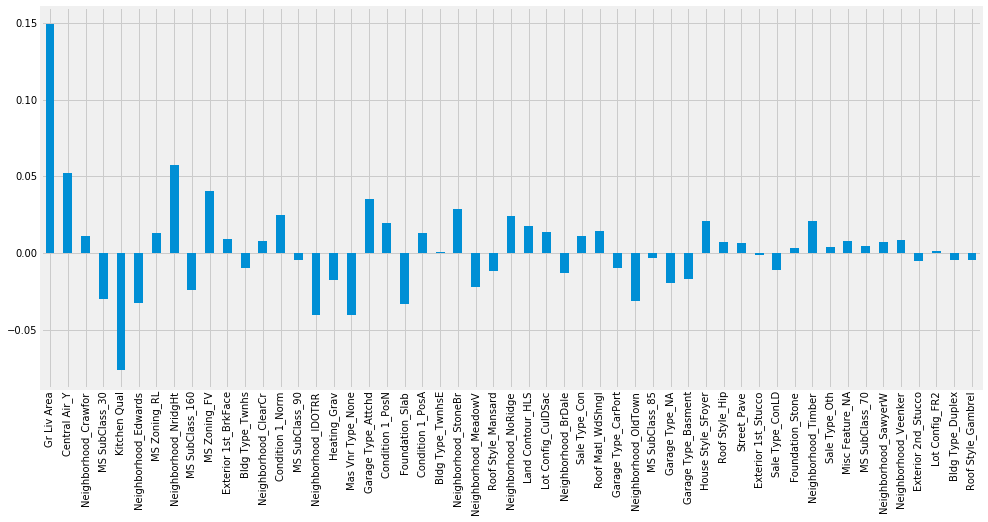

In [79]:
pd.Series(ridge_model.coef_, index=X2.columns).plot.bar(figsize=(15, 7))

In [80]:
#convert back to the normal price via e^i
y_pred2 = np.exp(ridge_model.predict(Xs_test2))
y_test2 = np.exp(y_test2)

In [81]:
residuals = y_test2 - y_pred2

In [82]:
ridge_mse = mean_squared_error(y_test2, y_pred2)
ridge_rmse = np.sqrt(ridge_mse)

print(ridge_mse)
print(ridge_rmse)

1216826808.8664415
34883.04471898119


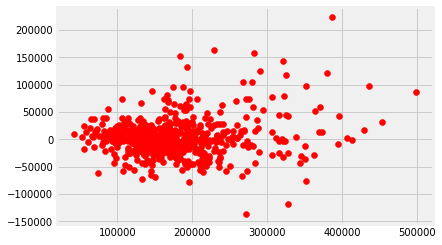

In [83]:
plt.scatter(y_pred2, residuals,color='red')

In [84]:
ames_test = pd.read_csv('datasets/test.csv')

In [85]:
explore(ames_test)

(879, 80)

     Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0  2658  902301120          190        RM          69.0      9142   Pave   
1  2718  905108090           90        RL           NaN      9662   Pave   
2  2414  528218130           60        RL          58.0     17104   Pave   
3  1989  902207150           30        RM          60.0      8520   Pave   
4   625  535105100           20        RL           NaN      9500   Pave   

  Alley Lot Shape Land Contour Utilities Lot Config Land Slope Neighborhood  \
0  Grvl       Reg          Lvl    AllPub     Inside        Gtl      OldTown   
1   NaN       IR1          Lvl    AllPub     Inside        Gtl       Sawyer   
2   NaN       IR1          Lvl    AllPub     Inside        Gtl      Gilbert   
3   NaN       Reg          Lvl    AllPub     Inside        Gtl      OldTown   
4   NaN       IR1          Lvl    AllPub     Inside        Gtl        NAmes   

  Condition 1 Condition 2 Bldg Type House Style  Overall 

In [86]:
ames_test.loc[(ames_test['Pool QC'].isin([np.nan]))]

Id         PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0    2658   902301120          190        RM          69.0      9142   Pave   
1    2718   905108090           90        RL           NaN      9662   Pave   
2    2414   528218130           60        RL          58.0     17104   Pave   
3    1989   902207150           30        RM          60.0      8520   Pave   
4     625   535105100           20        RL           NaN      9500   Pave   
5     333   923228370          160        RM          21.0      1890   Pave   
6    1327   902427150           20        RM          52.0      8516   Pave   
7     858   907202130           20        RL           NaN      9286   Pave   
8      95   533208090          160        FV          39.0      3515   Pave   
9    1568   914476010           20        RL          75.0     10125   Pave   
10   2482   531452100          120        RL          50.0      7175   Pave   
11   1364   903455140           30        RM          60.0      7200   Pave   
12   2584   535303050           20        RL          75.0     11310   Pave   
13    818   906230030           90        RL           NaN      7976   Pave   
14   2673   903206160           70        RL          69.0     11737   Pave   
15   2089   905480180           20        RL          60.0      9060   Pave   
16   1297   902128150          190        RM          60.0     10800   Pave   
17    790   905451300           20        RL          68.0      9571   Pave   
18   2616   535425040           20        RL          80.0     10800   Pave   
19    720   902330040           70        RM         121.0     17671   Pave   
20    222   905105070           20        RL           NaN      8246   Pave   
21    557   532354160           20        RL           NaN      8499   Pave   
22   1148   531451020          120        RL          50.0      8012   Pave   
23   2766   906475050           80        RL           NaN     21453   Pave   
24    534   531363010           20        RL          80.0      9605   Pave   
25   1452   907227050           20        RL          60.0      7180   Pave   
26    630   535150070           50        RL           NaN     12513   Pave   
27   2648   902125020           70        RM          50.0      9000   Pave   
28    125   534425310           85        RL          80.0      8800   Pave   
29   1904   534451020           50        RL          51.0      3500   Pave   
30   1670   527404150           20        RL           NaN      7340   Pave   
31    756   903458170           30        RM          52.0      6240   Pave   
32    717   902326030           70        RM          65.0     11700   Pave   
33   1032   527378020           20        RL          80.0     10000   Pave   
34    852   907196060           20        RL          75.0     11166   Pave   
35   1731   528218100           60        RL          58.0     13204   Pave   
36   2639   902103090           50        RM          60.0      5520   Pave   
37   2071   905228020           20        RL           NaN      9000   Pave   
38   1267   535451010           20        RL          74.0      8892   Pave   
39   1851   533242080           20        FV          73.0      7321   Pave   
40    567   533210010          160        FV          40.0      3951   Pave   
41   2439   528280100           60        RL           NaN     11214   Pave   
42   1898   534427140           20        RL          75.0      7388   Pave   
43    647   535351050           20        RL          75.0     14559   Pave   
44   2256   916226090          120        RL          46.0      4054   Pave   
45    979   923228150          160        RM          21.0      1533   Pave   
46   1444   907196050           60        RL          68.0     11250   Pave   
47   2485   531479030           20        RH          60.0      7800   Pave   
48    157   535350040           20        RL          74.0      5868   Pave   
49     88   532377100           20        RL          75.

In [87]:
#Replacing the np.nan cells to their respective column values

#changing to 0 for no lot frontage, 160 entries
ames_test['Lot Frontage'] = ames_test['Lot Frontage'].replace({np.nan:0})
#Changing to NA for no alley access
ames_test['Alley'] = ames_test['Alley'].replace({np.nan:'NA'})

#both 'Mas Vnr Type' and 'Mas Vnr Area' are 1 entry that are tied to each other
ames_test['Mas Vnr Type'] = ames_test['Mas Vnr Type'].replace({np.nan:'None'})
ames_test['Mas Vnr Area'] = ames_test['Mas Vnr Area'].replace({np.nan:0})

#25 entries without basement
ames_test['Bsmt Qual'] = ames_test['Bsmt Qual'].replace({np.nan:'NA'})
ames_test['Bsmt Cond'] = ames_test['Bsmt Cond'].replace({np.nan:'NA'})
ames_test['Bsmt Exposure'] = ames_test['Bsmt Exposure'].replace({np.nan:'NA'})
ames_test['BsmtFin Type 1'] = ames_test['BsmtFin Type 1'].replace({np.nan:'NA'})
ames_test['BsmtFin Type 2'] = ames_test['BsmtFin Type 2'].replace({np.nan:'NA'})

#1 electrical entry without additional information
ames_test.iloc[635, ames_test.columns.get_loc('Electrical')] = 'Mixed'

#All fireplace Qu with np.nan is does not have a fireplace,422 entries
ames_test['Fireplace Qu'] = ames_test['Fireplace Qu'].replace({np.nan:'NA'})

#All except for row765, does not have a garage. 44 entries without garage
ames_test['Garage Type'] = ames_test['Garage Type'].replace({np.nan:'NA'})
ames_test.iloc[765, ames_test.columns.get_loc('Garage Yr Blt')] = ames_test.iloc[765, ames_test.columns.get_loc('Year Remod/Add')]
ames_test['Garage Yr Blt'] = ames_test['Garage Yr Blt'].replace({np.nan:0})
ames_test['Garage Finish'] = ames_test['Garage Finish'].replace({np.nan:'NA'})
ames_test['Garage Qual'] = ames_test['Garage Qual'].replace({np.nan:'NA'})
ames_test['Garage Cond'] = ames_test['Garage Cond'].replace({np.nan:'NA'})


#All Pool QC with np.nan has pool area of 0
ames_test['Pool QC'] = ames_test['Pool QC'].replace({np.nan:'NA'})
ames_test['Fence'] = ames_test['Fence'].replace({np.nan:'NA'})
ames_test['Misc Feature'] = ames_test['Misc Feature'].replace({np.nan:'NA'})

In [88]:
def transform2(col):
    for i in col:
        le.fit(ames_test[i])
        list(le.classes_)
        ames_test[i] = le.transform(ames_test[i])

transform2(columns)

In [89]:
ames_test = pd.get_dummies(data = ames_test, prefix=column2, columns = column2, drop_first=True)

In [90]:
#Split so that dummy variables doesn't need to be scaled
ames1_test=ames_test.iloc[:,0:64]
ames2_test=ames_test.iloc[:,64:]

In [91]:
#Standarizing all other columns
ames1s_test = ss.fit_transform(ames1_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [92]:
#convert them back to DataFrames
ames1s_test=pd.DataFrame(ames1s_test, columns = ames_test.iloc[:,0:64].columns)
ames2_test=pd.DataFrame(ames2_test, columns = ames_test.iloc[:,64:].columns)

In [93]:
#combine them back
ames_test_s = pd.concat([ames1s_test,ames2_test], axis=1,sort=False)

In [94]:
X_test_final = ames_test_s[[
"Gr Liv Area",
"Central Air_Y",
"Neighborhood_Crawfor",
"MS SubClass_30",
"Kitchen Qual",
"Neighborhood_Edwards",
"MS Zoning_RL",
"Neighborhood_NridgHt",
"MS SubClass_160",
"MS Zoning_FV",
"Exterior 1st_BrkFace",
"Bldg Type_Twnhs",
"Neighborhood_ClearCr",
"Condition 1_Norm",
"MS SubClass_90",
"Neighborhood_IDOTRR",
"Heating_Grav",
"Mas Vnr Type_None",
"Garage Type_Attchd",
"Condition 1_PosN",
"Foundation_Slab",
"Condition 1_PosA",
"Bldg Type_TwnhsE",
"Neighborhood_StoneBr",
"Neighborhood_MeadowV",
"Roof Style_Mansard",
"Neighborhood_NoRidge",
"Land Contour_HLS",
"Lot Config_CulDSac",
"Neighborhood_BrDale",
"Sale Type_Con",
"Roof Matl_WdShngl",
"Garage Type_CarPort",
"Neighborhood_OldTown",
"MS SubClass_85",
"Garage Type_NA",
"Garage Type_Basment",
"House Style_SFoyer",
"Roof Style_Hip",
"Street_Pave",
"Exterior 1st_Stucco",
"Sale Type_ConLD",
"Foundation_Stone",
"Neighborhood_Timber",
"Sale Type_Oth",
"Misc Feature_NA",
"MS SubClass_70",
"Neighborhood_SawyerW",
"Neighborhood_Veenker",
"Exterior 2nd_Stucco",
"Lot Config_FR2",
"Bldg Type_Duplex",
"Roof Style_Gambrel"]]

In [95]:
y_pred = np.exp(ridge_model.predict(X_test_final))
y_pred = pd.DataFrame(y_pred, columns = ['SalePrice'])

In [96]:
final = pd.concat([ames_test.iloc[:,0],y_pred], axis=1)

In [97]:
final = final.sort_values(by=['Id'],ascending=True)
final

Id      SalePrice
704     2  140458.875277
706     4  268794.907489
120     6  210636.260993
312     7  192822.848983
401    17  177142.599274
316    18  265315.419921
791    22  189275.982765
608    27  145255.153812
391    31  146172.285980
753    36  165642.693574
317    39  279764.297059
324    40  219201.475753
710    42  259504.302917
453    46  207887.580115
168    53  184658.430938
620    58  164274.272989
201    61  282857.173637
643    72  199926.447766
469    79  140967.607179
441    80  209619.357454
393    82  185389.586076
479    83  115785.996649
587    85  173284.811622
49     88  148296.541058
794    92  267322.641283
345    93  257943.632983
8      95  207538.569768
636   102  198893.044693
648   103  185385.513348
346   106  223050.781123
340   107  156586.731145
590   110  201313.252415
108   114  194243.054506
141   116  190969.691617
686   117  180956.343763
830   118  168472.941022
28    125  178420.832653
814   126  183096.912756
142   127  175009.948044
667   128  230240.295316
708   134  169068.021535
134   135  185412.630797
847   137  219025.902776
267   143  164501.413285
740   147  167216.013461
516   148  184964.752124
477   150  177807.615929
676   156  160433.636013
48    157  147532.027525
222   159  143503.691735
356   161  297079.854635
651   167  153991.713917
233   170  182541.579375
257   171  141813.761215
856   175  156286.922509
93    179  179578.678726
744   181  145404.121089
51    186  232011.556756
188   193  212003.853789
448   194  121116.563547
599   206  117846.322414
117   208  193617.115565
795   210  186859.695124
363   211  157527.388632
497   212  149644.858308
804   214  174178.544908
407   215  170023.125046
110   217  177225.085139
20    222  172917.635629
133   227  170581.033356
813   228  178481.093978
843   233  199153.496886
511   235  206957.707940
290   238  151619.368269
609   241  174864.932188
395   252  181386.066266
534   253  188690.250855
541   256  160084.827759
574   257  151352.373171
747   258  183422.646776
344   259  215421.979896
148   261  174121.987489
87    263  140046.002283
408   266  227759.477510
762   267  233174.359959
578   270  167358.902171
700   271  216331.160545
528   276  158010.660185
743   285  168469.341452
634   288  110012.066550
323   289  202062.111547
225   290  120213.212045
315   291  214922.731802
181   292  168204.402833
632   293  242919.174274
136   294  219360.955465
631   295  212588.535736
82    304  144380.584112
245   322  269083.024462
571   326  165928.993225
678   327  145539.617819
192   328  141470.246096
232   331  126202.498035
157   332  137842.259448
5     333  145539.617819
389   335  167437.566763
869   337  223191.629065
247   342  145255.153812
111   343  178565.668774
767   347  179744.526332
629   350  274828.240010
857   352  177409.684461
745   358  171748.022553
473   359  197187.548266
770   360  186959.113842
872   368  247791.950643
693   369  213570.717460
727   373  177386.652076
413   377  276784.693157
742   383  229075.425981
112   386  219225.759277
456   387  220686.357597
58    390  158867.099575
185   391  174297.259886
55    395  165377.333723
74    397  158778.703986
275   398  139562.794941
419   401  139758.457579
863   404  158835.753280
724   408  155286.446341
326   409  148555.835905
558   410  166206.604774
531   418  143426.355334
238   422  341490.743501
86    427  288105.322597
426   431  286285.493543
164   433  341651.417368
71    437  321410.262657
404   438  230400.662988
383   442  258603.716100
798   447  216565.748690
302   459  275447.490682
165   460  243501.191166
842   464  209522.433442
808   465  189064.391098
501   467  195378.452874
224   468  192873.721585
831   474  184658.430938
434   480  201667.708389
187   481  195660.026066
379   483  203167.818176
249   488  192240.067935
650   492  174281.054984
803   494  164274.272989
416   499  290339.275454
230   500  266937.938844
65    501  251206.502938
298   503  246042.626766
286   506  215015.118242
751   5

In [99]:
final.to_csv("datasets/final5.csv", index=False) 